In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import xlsxwriter
from openpyxl import load_workbook

In [2]:
TEAMS= ["ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]
WESTERN_CONF_TEAMS = ["DAL", "DEN", "GSW", "HOU", "LAC", "LAL", "MEM", "MIN", "NOP", "OKC", "PHO", "POR", "SAC", "SAS", "UTA"]
EASTERN_CONF_TEAMS = ["ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DET", "IND", "MIA", "MIL", "NYK", "ORL", "PHI", "TOR", "WAS"]
ATLANTIC_DIV_TEAMS = ["BOS", "BRK", "NYK", "PHI", "TOR"]
CENTRAL_DIV_TEAMS = ["CHI", "CLE", "DET", "IND", "MIL"]
SOUTHEAST_DIV_TEAMS = ["ATL", "CHO", "MIA", "ORL", "WAS"]
NORTHWEST_DIV_TEAMS = ["DEN", "MIN", "OKC", "POR", "UTA"]
SOUTHWEST_DIV_TEAM = ["GSW", "LAC", "LAL", "PHO", "SAC"]
PACIFIC_DIV_TEAMS = ["DAL", "HOU", "MEM", "NOP", "SAS"]
SEASONS = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
POSITIONS = ["PG", "SG", "SF", "PF", "C"]

In [3]:
def mean(data):
    return sum(data) / len(data)

In [4]:
def variance(data):
    n = len(data)
    avg = mean(data)
    
    deviations = [(x - avg) ** 2 for x in data]
    
    variance = sum(deviations) / n
    return variance

In [5]:
def std(data):
    var = variance(data)
    std = var ** 0.5
    return std

In [6]:
def growth_rate(data):
    straight_line_growth = []
    
    for i in range(1, len(data)):
        growth = (data[i] - data[i-1]) / data[i-1]
        straight_line_growth.append(growth)
        
    growth_rt = sum(straight_line_growth) / len(straight_line_growth)
    
    return "{:.2f}%".format(growth_rt*100)

In [7]:
def spearman_rank_corr(rank1, rank2):
    d_square = []
    
    if len(rank1) != len(rank2):
        return
    
    n = len(rank1)
    
    for i in range(n):
        d = rank1[i] - rank2[i]
        d_square.append(d ** 2)
    
    return 1 - ((6 * sum(d_square)) / (n * (n ** 2 - 1)))

In [8]:
def calculate_rank_corr_by_team_stat(df, eastern_standings, western_standings, stat):
    
    corr_df = df.sort_values(by=[stat, 'Team'], ascending=[False, True])
    
#     corr_df.set_index('Team', inplace=True)
    
    teams = list(corr_df.index)
    rank = range(1, 31)
    zip_iterator = zip(teams, rank)

    teams_ordered_by_stat = dict(zip_iterator)
    
    standings = merge_standings(eastern_standings, western_standings)
        
    rank1 = []
    rank2 = []
    for team in TEAMS:
        if team in standings:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings[team])

    return spearman_rank_corr(rank1, rank2)

In [9]:
def rank_team_corrs_to_excel(dfs, eastern_standings_dfs, western_standings_dfs, stat):
    corrs = [stat]
    
    n = len(dfs)
    
    for i in range(n):
        corrs.append(calculate_rank_corr_by_team_stat(dfs[i], eastern_standings_dfs[i], western_standings_dfs[i], stat))
        
    wb = load_workbook("Rank_Correlation_Starters_Stats.xlsx")
    ws = wb.worksheets[0]
    
    ws.append(corrs)
    wb.save("Rank_Correlation_Starters_Stats.xlsx")

In [10]:
def merge_standings(eastern_standings, western_standings):
    standings = pd.concat([western_standings, eastern_standings])
    standings.sort_values(by=["Made_Playoffs", "W", "Rank", "Team"], ascending=[False, False, True, True], inplace=True)
    standings.reset_index(inplace=True)
    standings.drop('index', axis=1, inplace=True)
    standings.index += 1
    teams_ranked = dict(standings["Team"])
    inv_teams_ranked = {v: k for k, v in teams_ranked.items()}
    return inv_teams_ranked

In [11]:
def format_season(season):
        #Formats years in season to use in File Name
        #Ex: 2021 turns into 2020-21
        first_year = season-1
        second_year = str(season)[2:]
        
        return first_year, second_year

In [15]:
def get_csvs_by_season(season):
    first_year, second_year = format_season(season)
    
    player_df = pd.read_csv("DataCollection/Player_Stats/player_stats_{0}-{1}.csv".format(first_year, second_year))
    team_df = pd.read_csv("DataCollection/Team_Stats/team_stats_{0}-{1}.csv".format(first_year, second_year))
    adv_team_df = pd.read_csv("DataCollection/Advanced_Team_Stats/adv_team_stats_{0}-{1}.csv".format(first_year, second_year))
    opponent_df = pd.read_csv("DataCollection/Opponent_Stats/opponent_stats_{0}-{1}.csv".format(first_year, second_year))
    eastern_standings_df = pd.read_csv("DataCollection/Standings/standings_eastern_conference_{0}-{1}.csv".format(first_year, second_year))
    western_standings_df = pd.read_csv("DataCollection/Standings/standings_western_conference_{0}-{1}.csv".format(first_year, second_year))
    
    return player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df

In [13]:
def round_closest_half(n):
    return round(n * 2) / 2

In [17]:
player_dfs, team_dfs, adv_team_dfs, opponent_dfs, eastern_standings_dfs, western_standings_dfs = [], [], [], [], [], []

for season in SEASONS:
    player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df = get_csvs_by_season(season)
    player_dfs.append(player_df)
    team_dfs.append(team_df)
    adv_team_dfs.append(adv_team_df)
    opponent_dfs.append(opponent_df)
    eastern_standings_dfs.append(eastern_standings_df)
    western_standings_dfs.append(western_standings_df)

In [18]:
starters_per_season = []

for i in range(len(SEASONS)):    
    df = player_dfs[i].sort_values(by=['Tm', 'GS'], ascending=[True, False])
    cols = df.columns    
    starters_df = pd.DataFrame(columns = cols)
    for team in TEAMS:
        starters = pd.DataFrame(df[df["Tm"] == team][:5])
        starters = starters.mean()
        starters_df.loc[team] = starters

    starters_df.drop(["Player", "Pos", "Tm"], axis=1, inplace=True)
    starters_df.index.names = ["Team"]
    starters_per_season.append(starters_df)

In [19]:
starters_per_season[18]

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary
Team,,,,,,,,,,,,,,,,,,,,,
ATL,24.2,60.4,53.0,30.72,6.36,12.86,0.4986,1.76,4.56,0.38575,...,22.72,4.06,1.86,5.92,0.1532,2.64,-2.400000e-01,2.40,2.00,7.367756e+06
BOS,26.2,53.4,50.6,31.76,6.54,14.42,0.4558,2.12,5.78,0.29460,...,23.96,2.46,1.70,4.16,0.1148,1.66,-5.000000e-01,1.14,1.52,1.814315e+07
BRK,29.4,62.6,47.4,27.42,5.22,9.80,0.5644,1.54,3.60,0.31540,...,18.24,3.60,1.38,5.00,0.1418,1.38,-2.200000e-01,1.20,1.42,1.229471e+07
CHI,23.4,55.0,47.0,30.52,6.50,13.78,0.4714,2.24,5.66,0.39180,...,23.36,1.58,1.64,3.24,0.0992,1.14,-4.000000e-01,0.74,0.96,9.718137e+06
CHO,26.2,59.6,50.8,29.92,5.20,11.60,0.4654,2.04,5.24,0.31300,...,20.12,1.84,1.62,3.42,0.0930,0.14,-1.400000e-01,0.00,0.98,1.101749e+07
CLE,22.6,53.4,48.8,32.46,5.54,11.52,0.4852,1.14,3.24,0.34640,...,19.92,1.34,1.14,2.48,0.0736,-0.52,-7.000000e-01,-1.24,0.20,6.746503e+06
DAL,25.8,55.6,53.0,30.86,5.58,12.04,0.4552,2.08,5.60,0.37200,...,20.74,2.62,1.72,4.34,0.1192,1.46,4.000000e-02,1.48,1.66,7.730317e+06
DEN,27.0,58.6,52.4,30.64,6.68,13.20,0.4974,1.90,4.68,0.39300,...,22.74,4.50,2.02,6.50,0.1594,3.02,2.600000e-01,3.26,2.80,1.138975e+07
DET,27.6,52.4,45.0,27.84,4.52,9.88,0.4704,1.60,4.26,0.30000,...,19.20,1.84,1.44,3.28,0.1102,0.84,2.600000e-01,1.10,1.10,8.072097e+06


In [22]:
starters_corr = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Starters_Stats.xlsx")
starters_corr.set_index("Stat", inplace=True)
starters_corr

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Stat,,,,,,,,,,,,,,,,,,,
Age,0.368473,0.376847,0.294772,0.471413,0.537709,0.443382,0.436263,0.546162,0.459844,0.303226,0.451390,0.495884,0.405562,0.364182,0.304116,0.414016,0.619577,0.633370,0.429143
G,0.117241,0.550739,0.406897,0.338821,0.435373,0.558176,0.245829,0.189321,0.187987,0.353949,0.327697,0.266296,0.503893,0.201780,0.190211,0.432703,0.521691,0.447831,0.582647
GS,0.397044,0.705911,0.539043,0.531034,0.488765,0.642269,0.632481,0.555951,0.559956,0.720578,0.503893,0.477642,0.759733,0.552392,0.468743,0.546162,0.709900,0.659177,0.579088
MP,0.198522,0.064039,0.307675,0.255617,0.094994,0.233370,-0.168409,0.004672,0.056285,0.463404,0.224027,0.221357,0.352169,0.024694,0.228476,0.343270,0.456730,0.089655,-0.001557
FG,0.440887,-0.001478,0.347720,0.305451,0.285873,0.305895,0.076307,0.384650,0.272080,0.545717,0.372191,0.229811,0.388209,0.355284,0.236485,0.473637,0.533704,0.255172,0.299221
FGA,0.222167,-0.149754,0.265406,0.164850,0.138598,0.144828,-0.243604,0.017130,-0.050945,0.406897,0.090990,-0.104338,0.037152,0.144383,0.170634,0.282759,0.485651,0.138598,0.026919
FG%,0.458128,0.444828,0.408231,0.511457,0.249833,0.449166,0.567964,0.513682,0.507008,0.505673,0.461624,0.682314,0.708565,0.422469,0.504338,0.587097,0.278754,0.511012,0.446941
3P,0.364532,-0.081281,0.498999,0.113237,0.066073,0.404227,0.094994,0.228031,0.103003,0.022024,0.342825,0.038487,0.419800,0.484761,0.249388,0.396218,0.353504,0.052725,0.094549
3PA,0.352217,-0.146305,0.461624,0.125695,0.007341,0.410901,-0.011791,0.188877,0.042047,-0.083871,0.240489,-0.058509,0.327697,0.399333,0.101224,0.287208,0.332592,0.022024,-0.014905


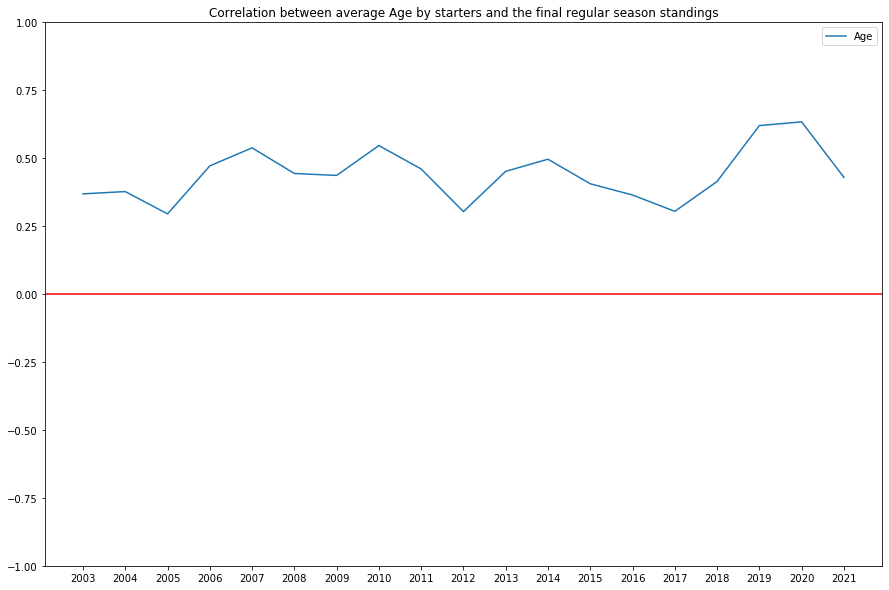

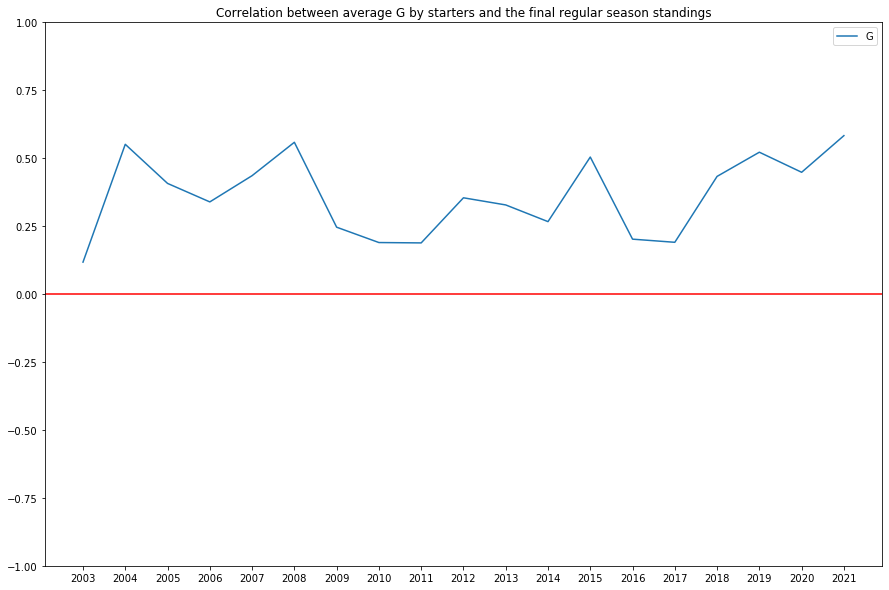

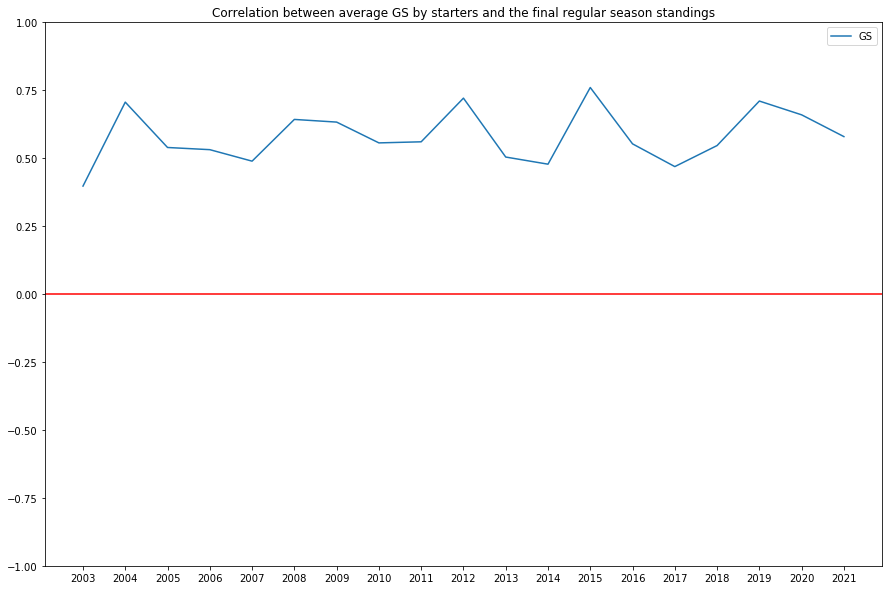

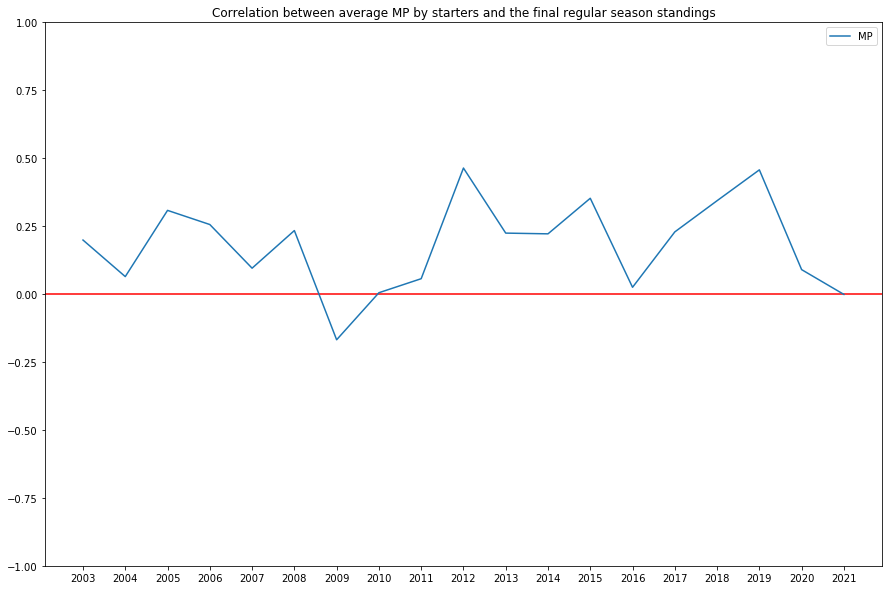

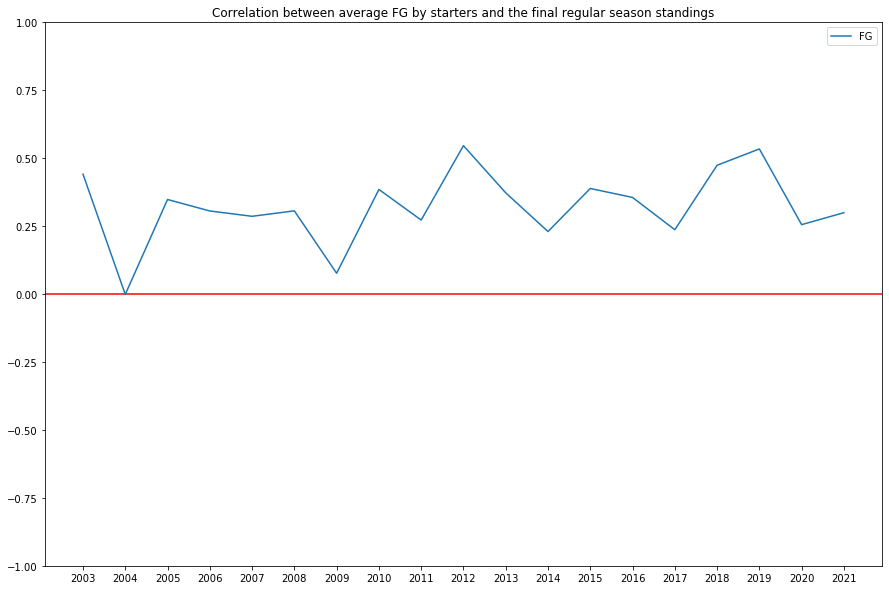

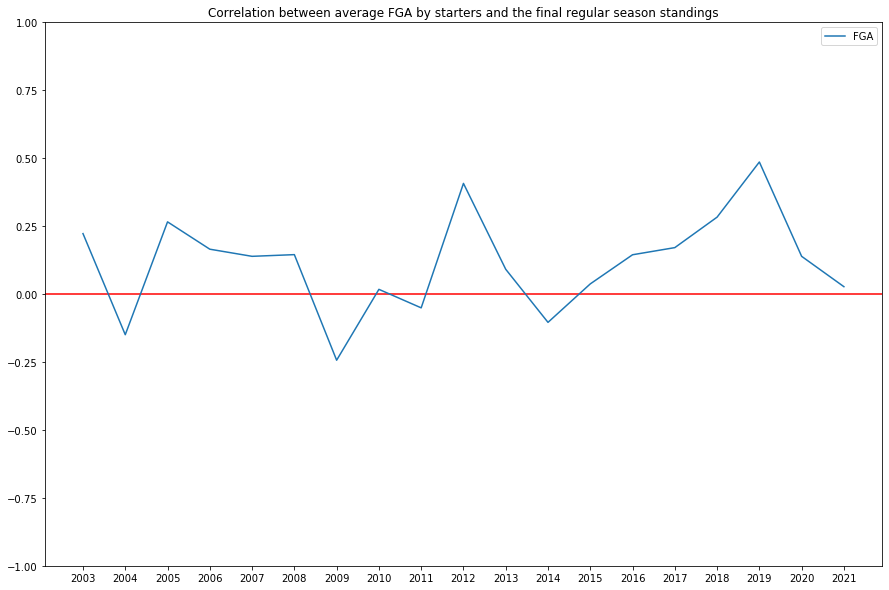

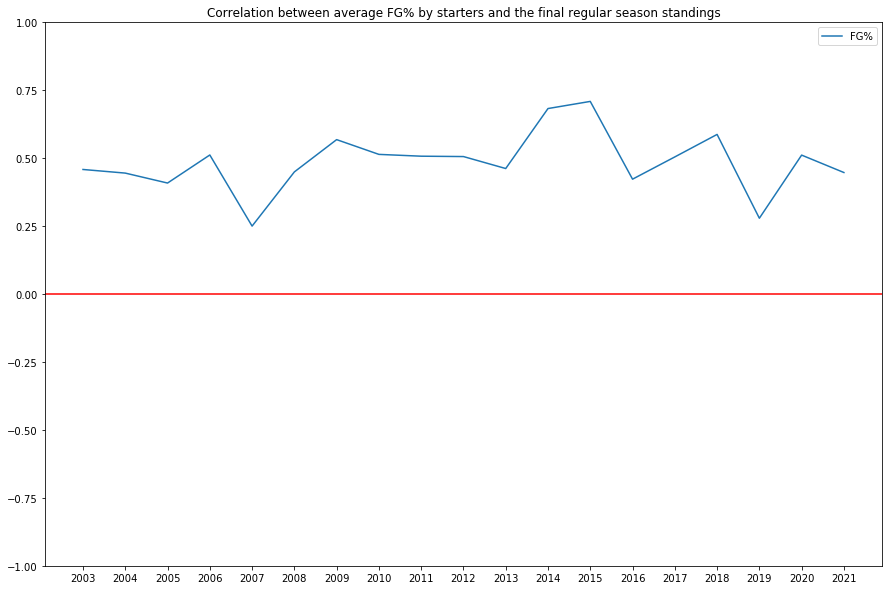

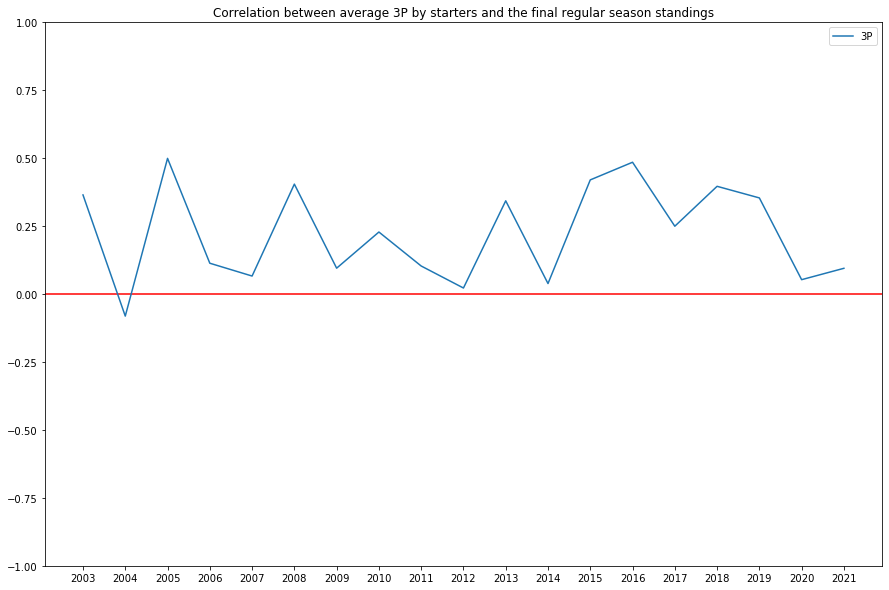

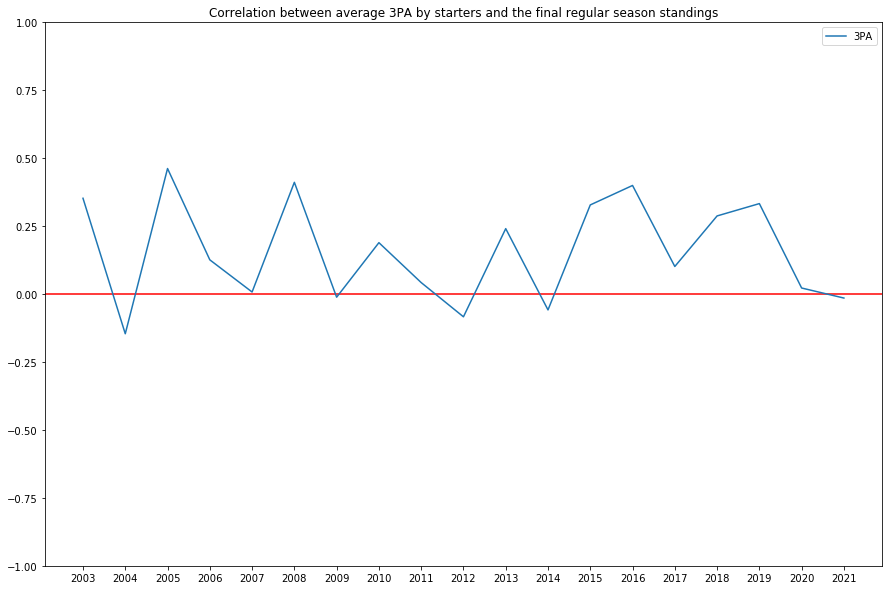

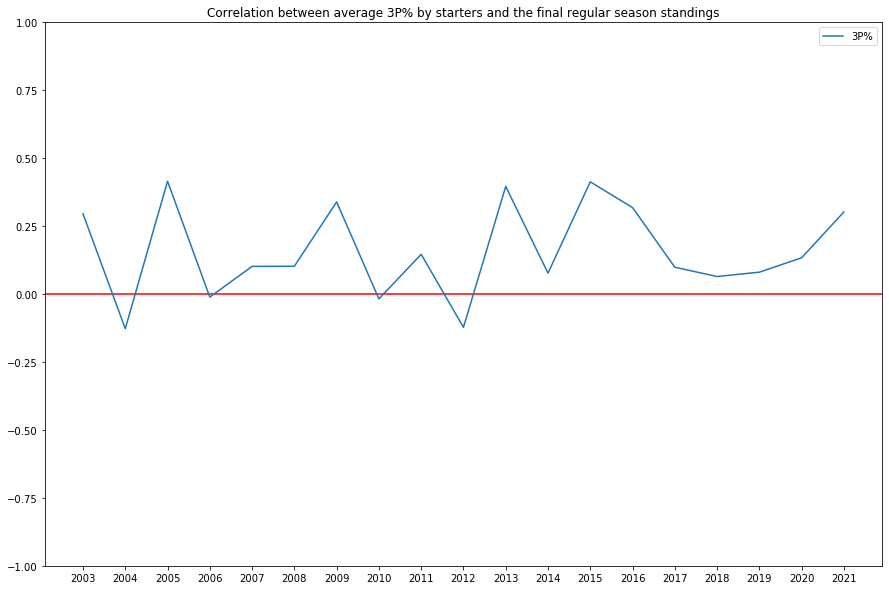

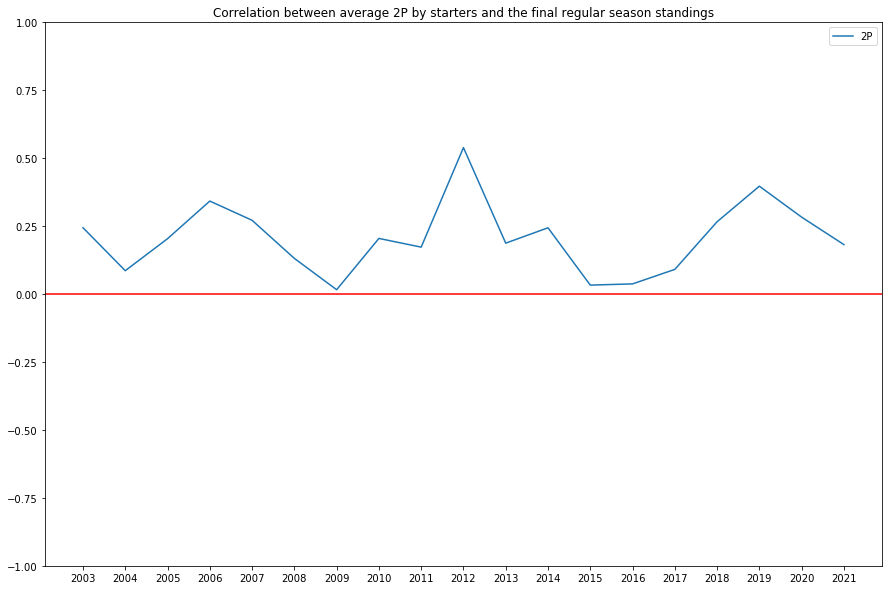

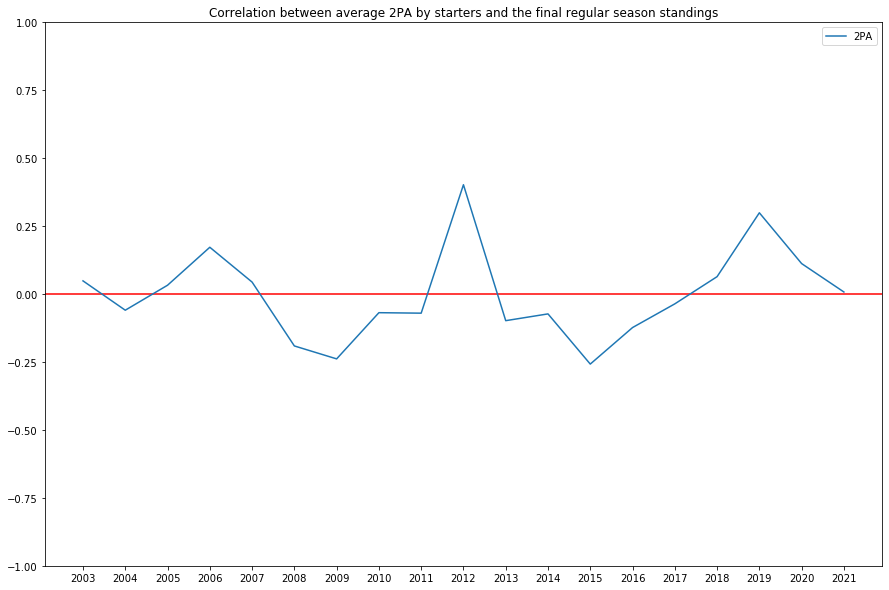

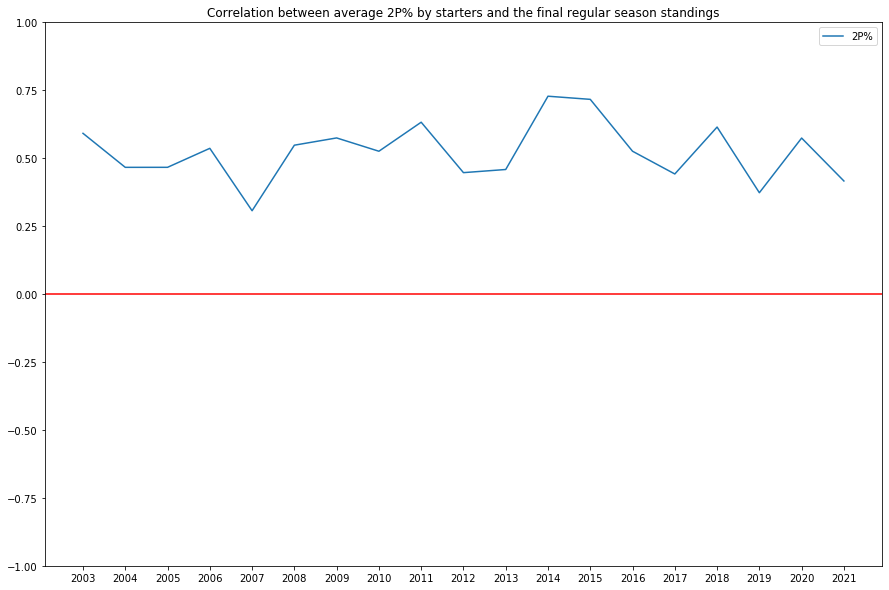

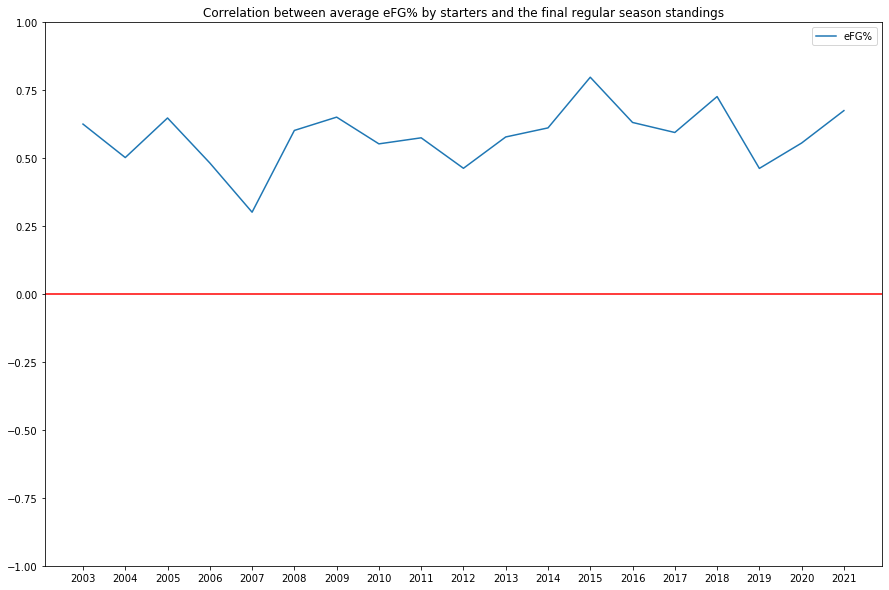

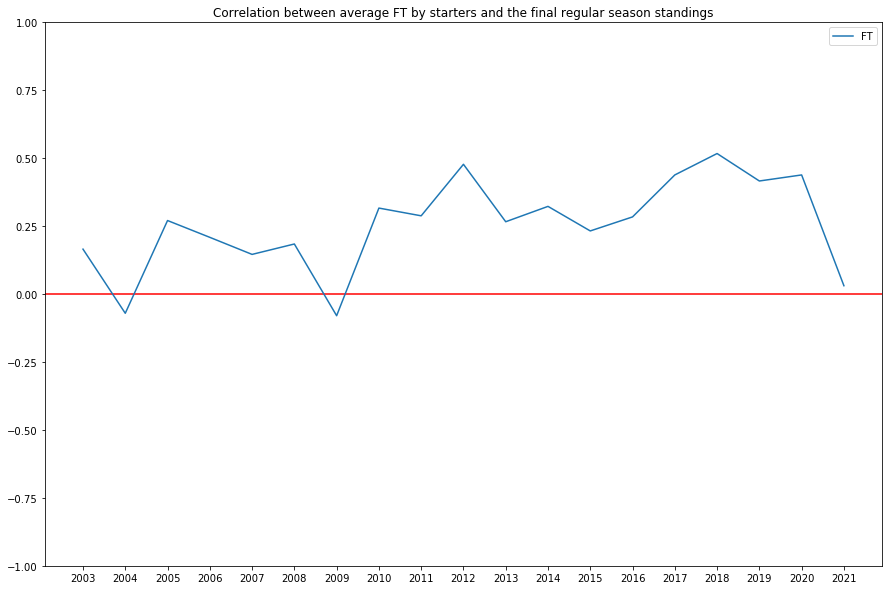

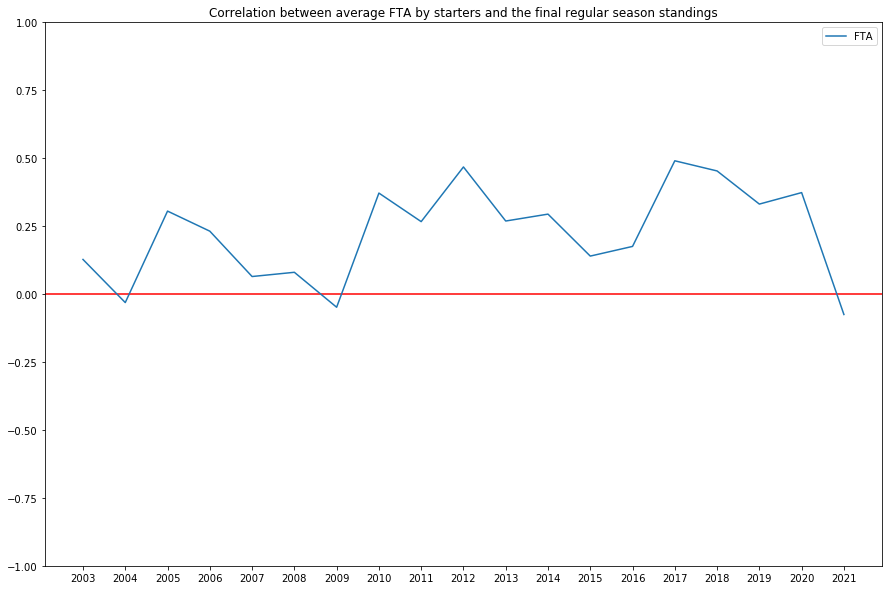

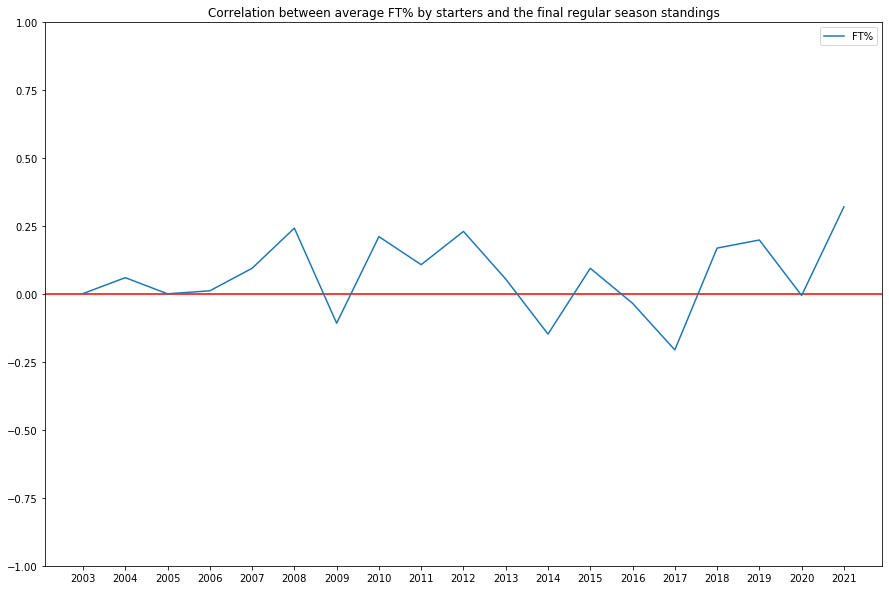

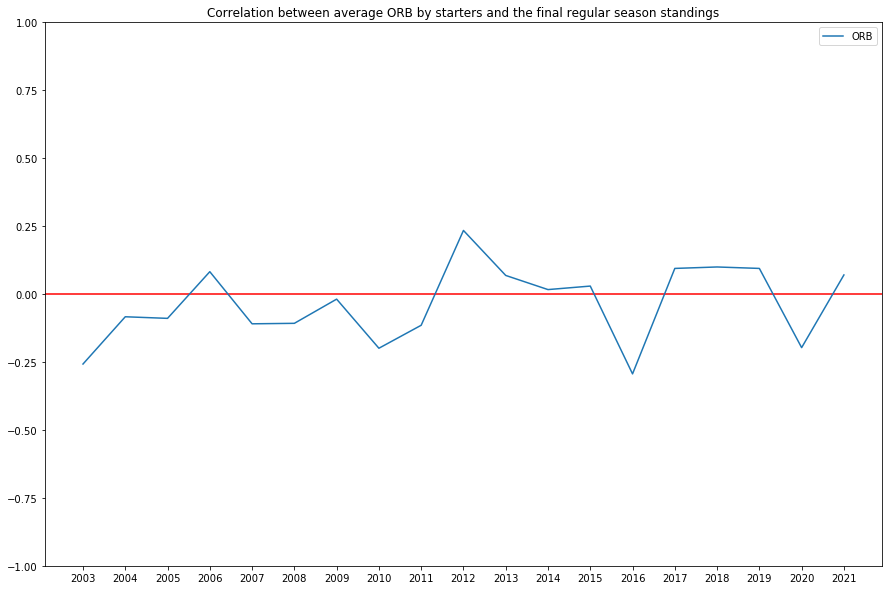

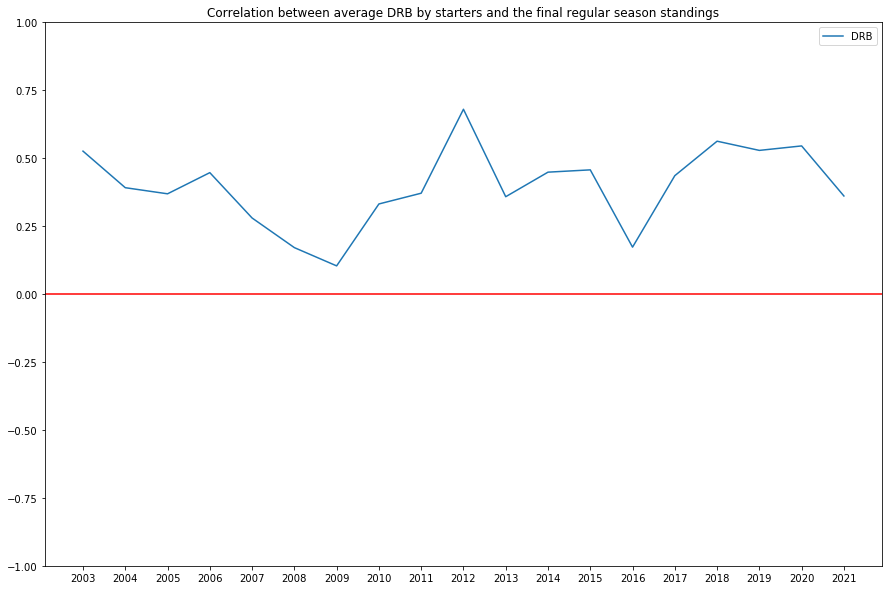

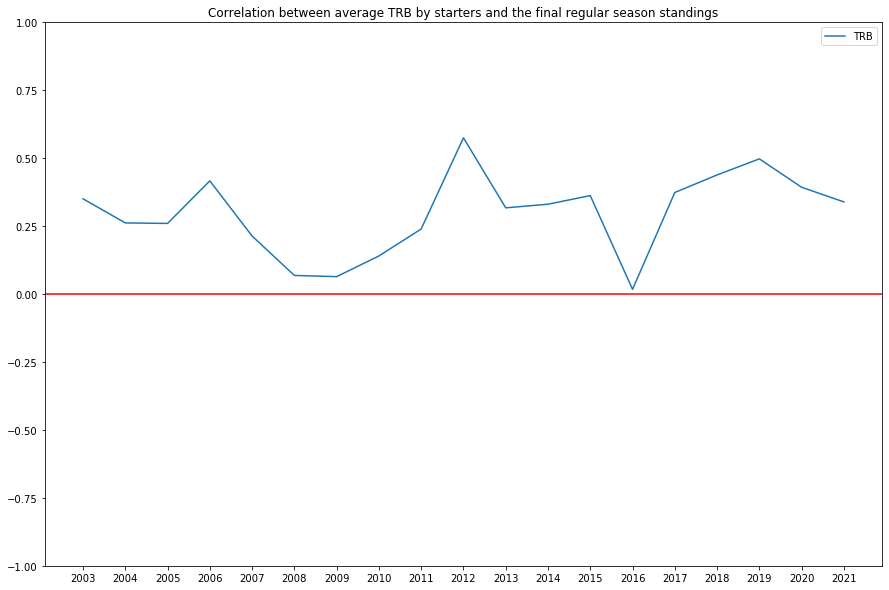

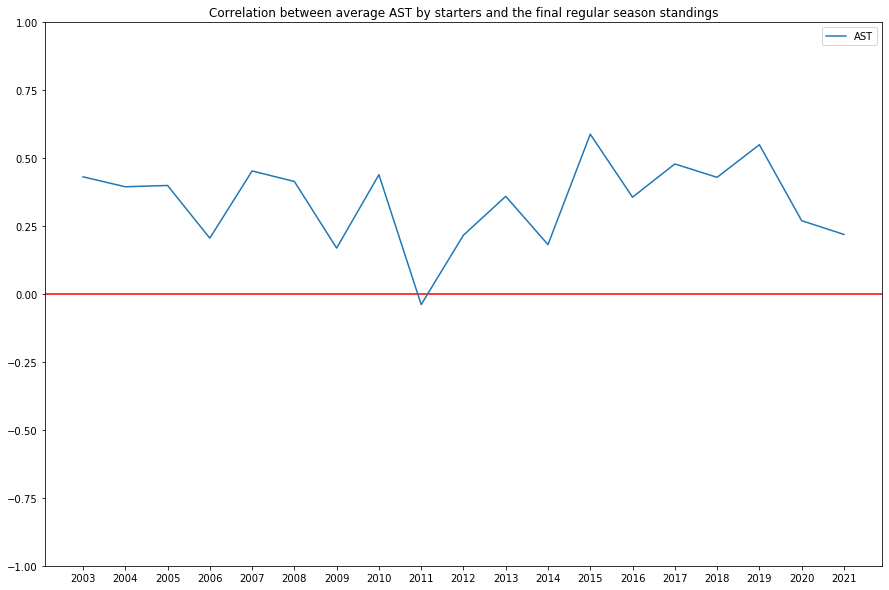

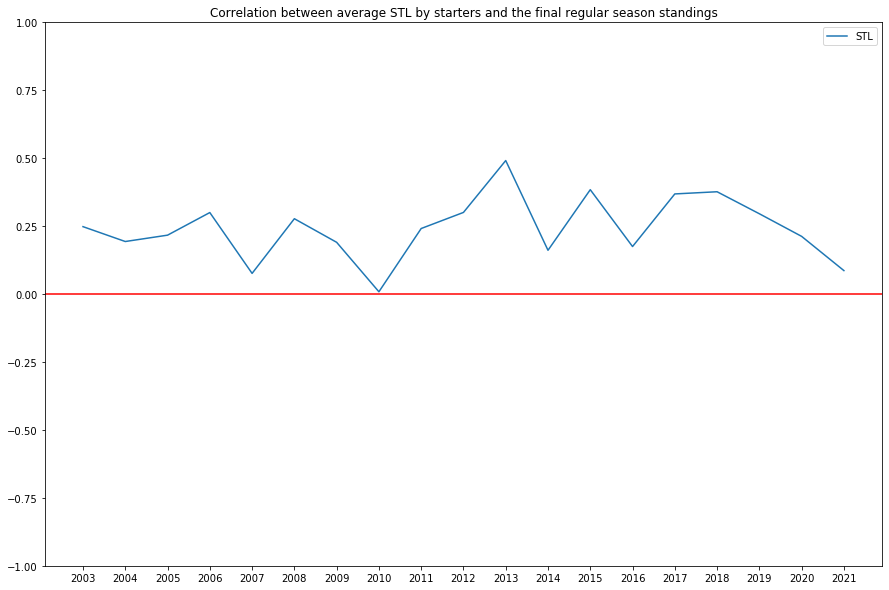

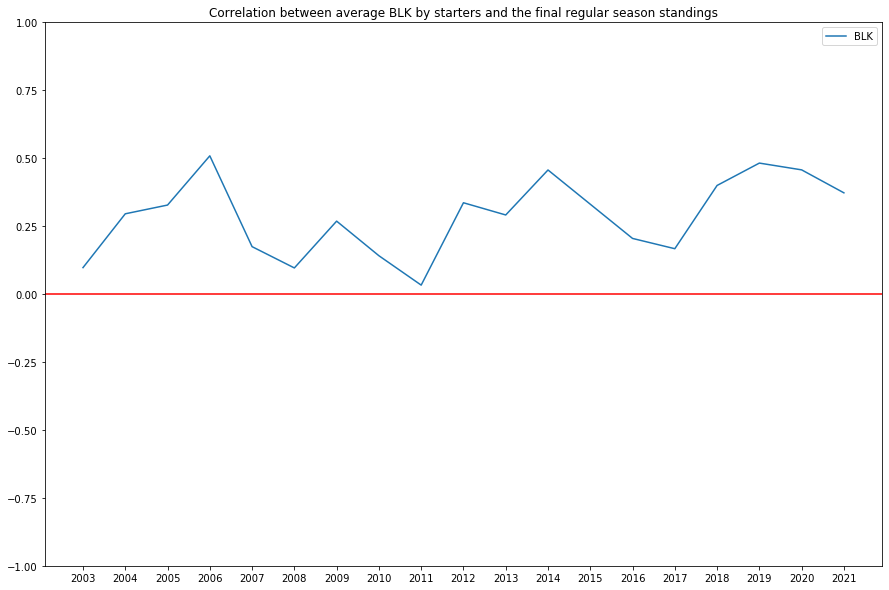

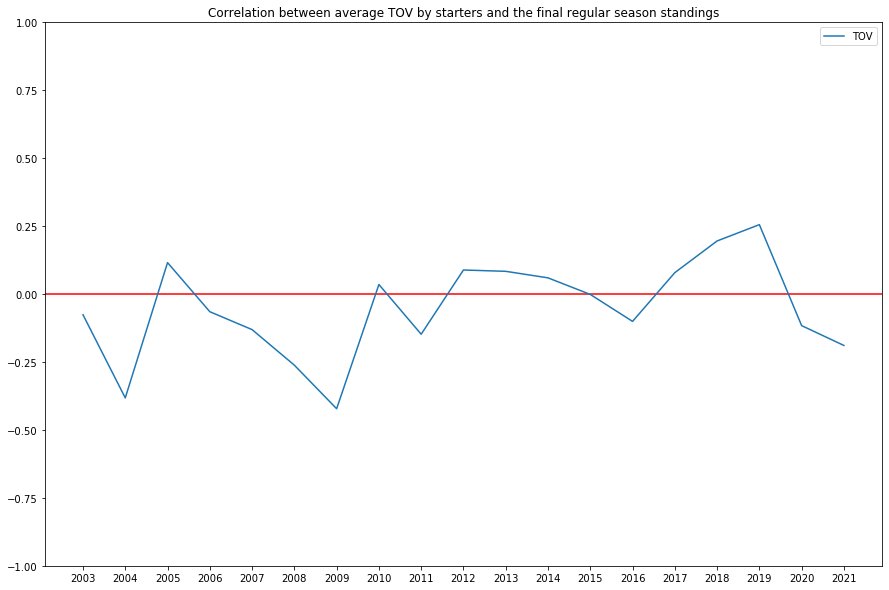

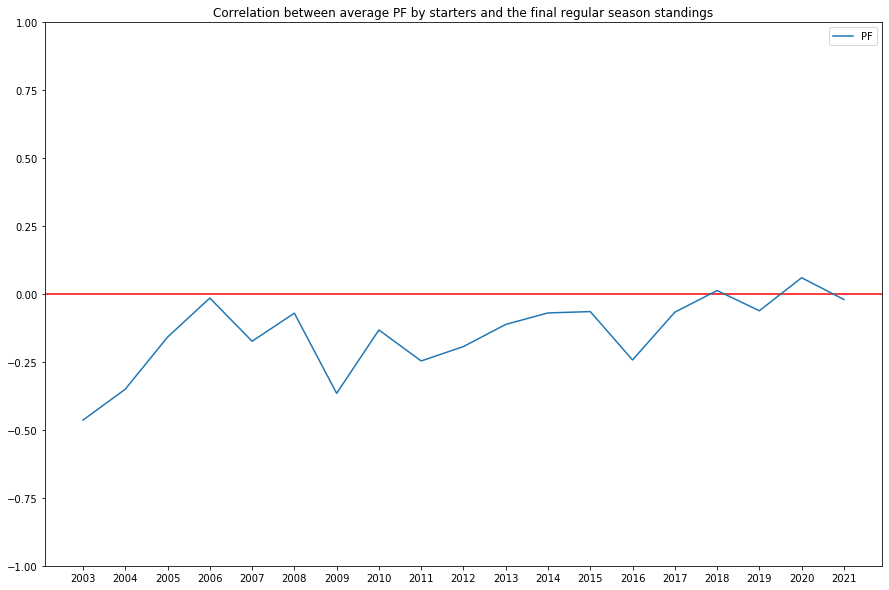

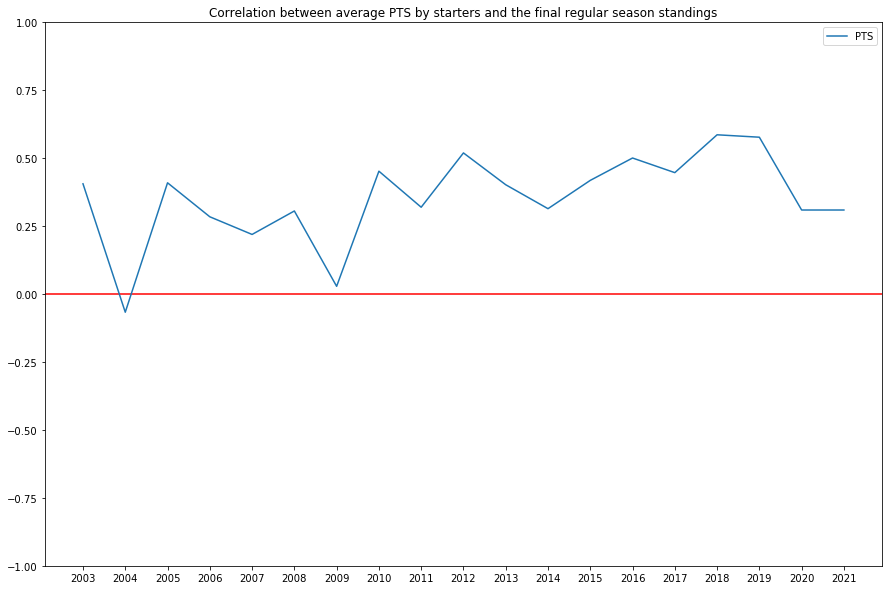

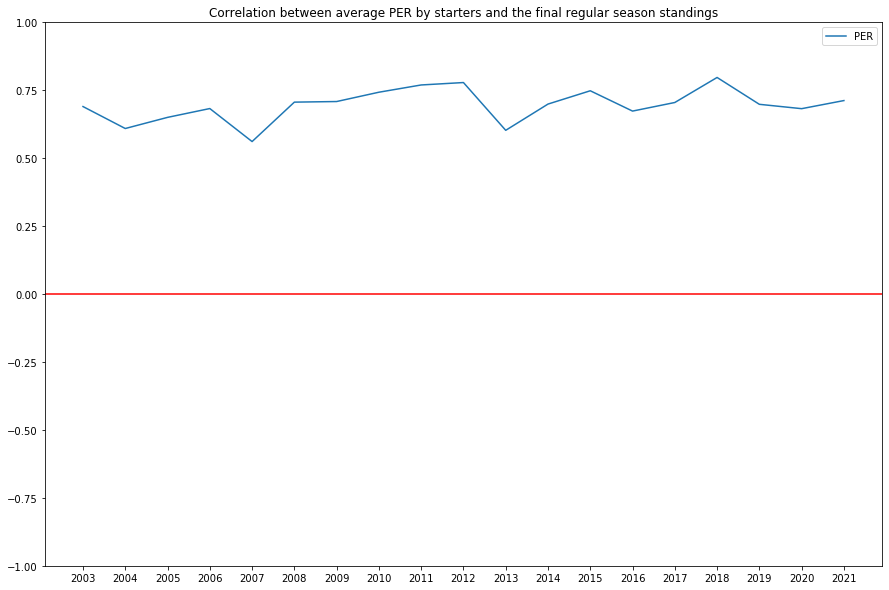

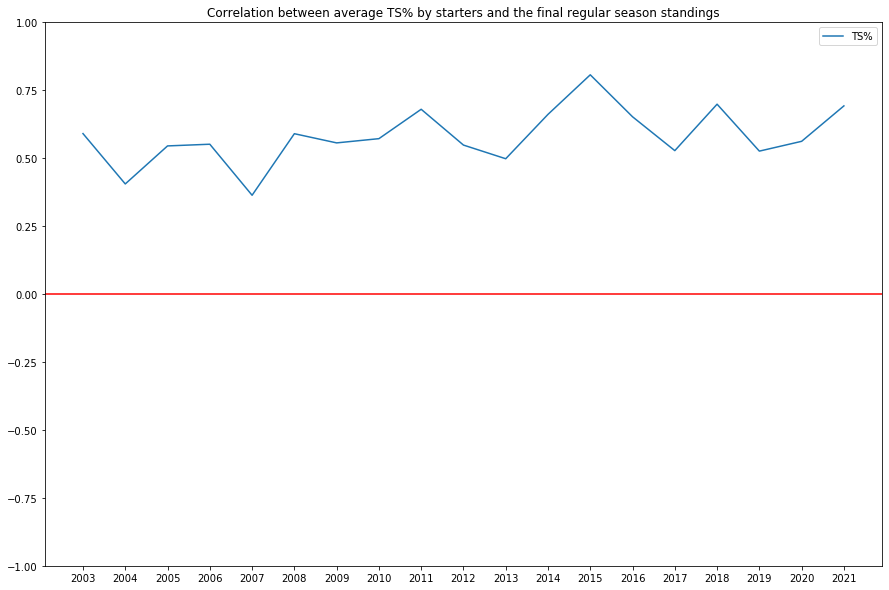

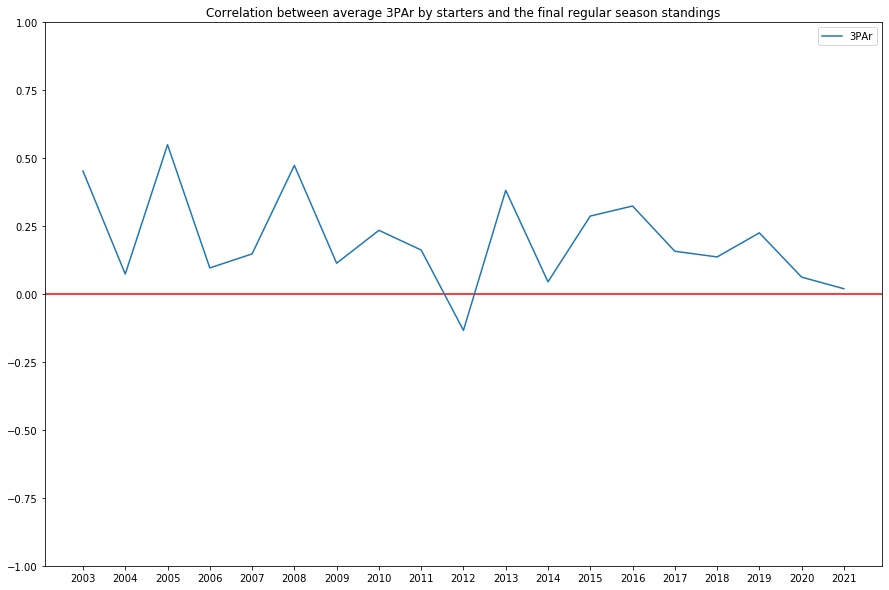

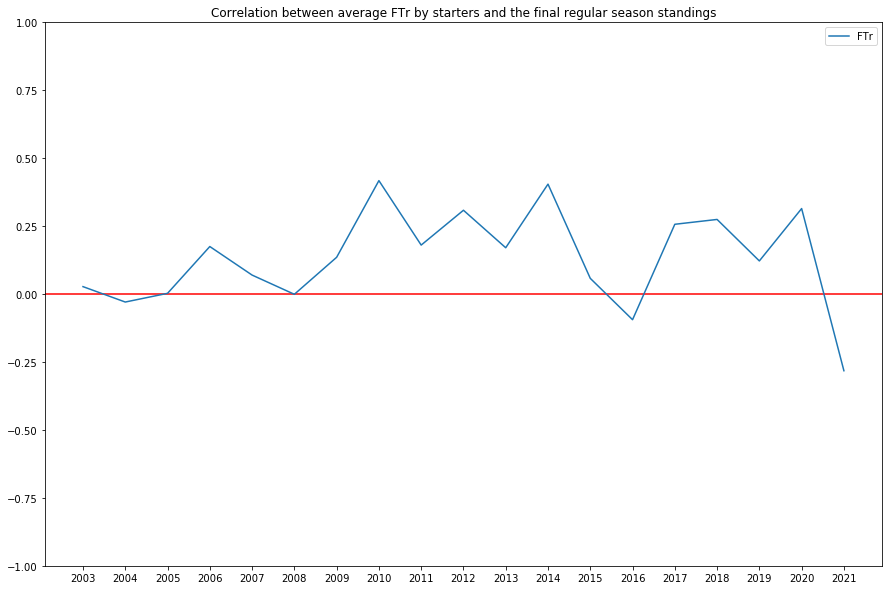

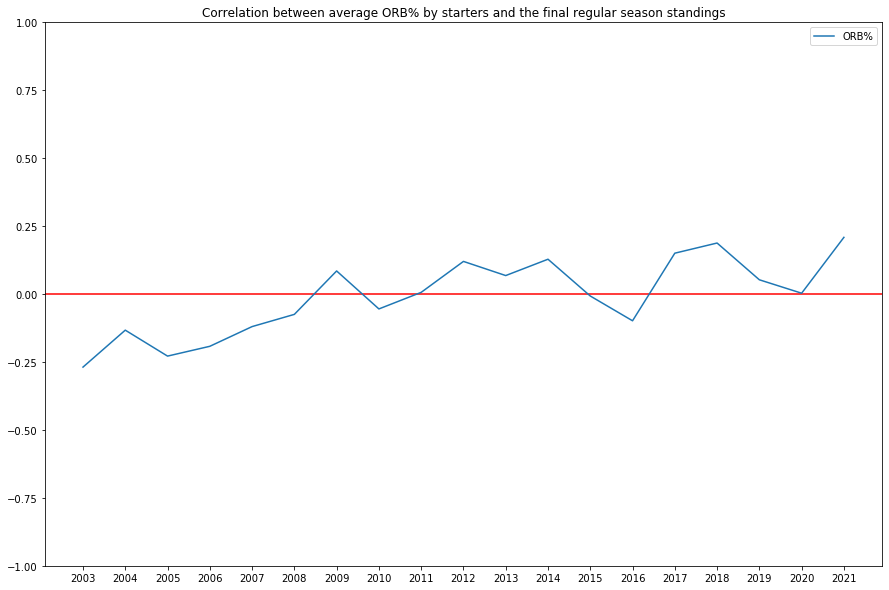

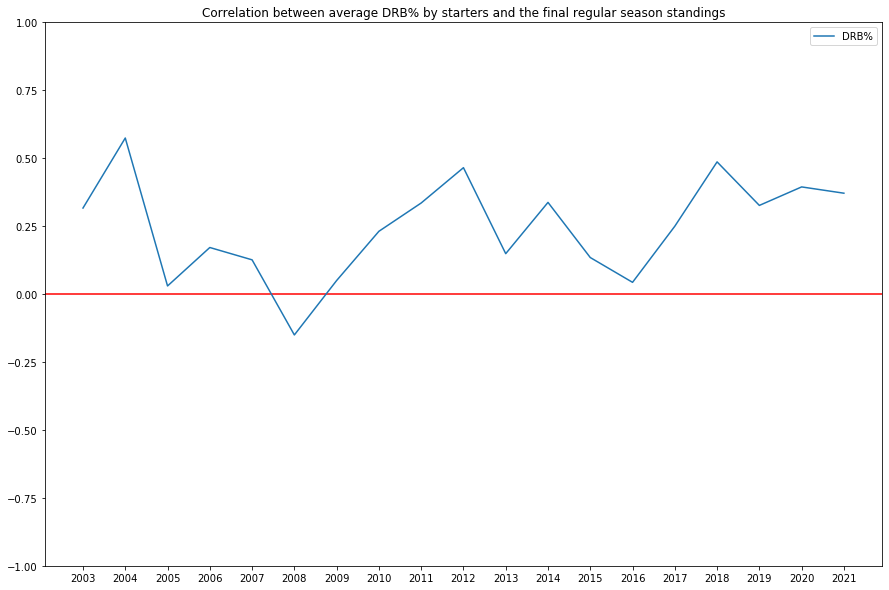

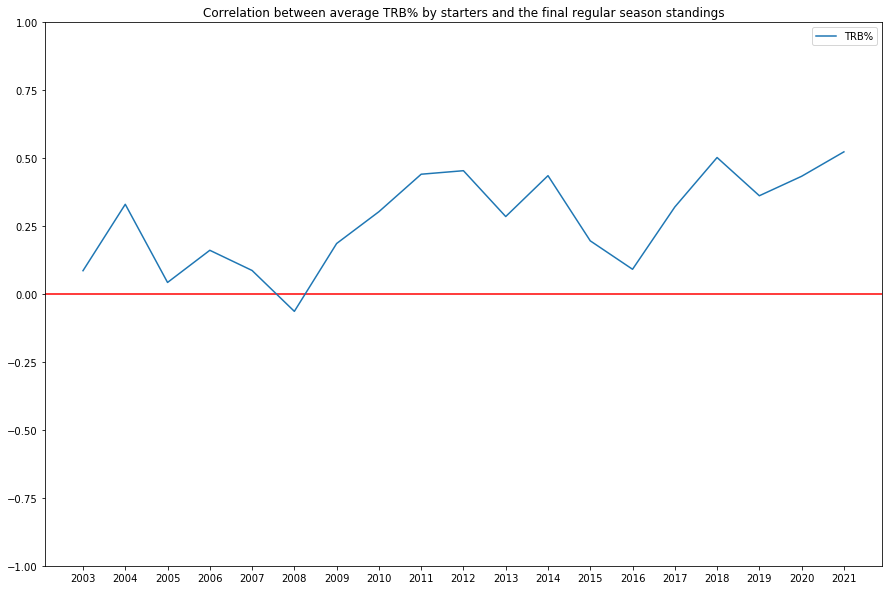

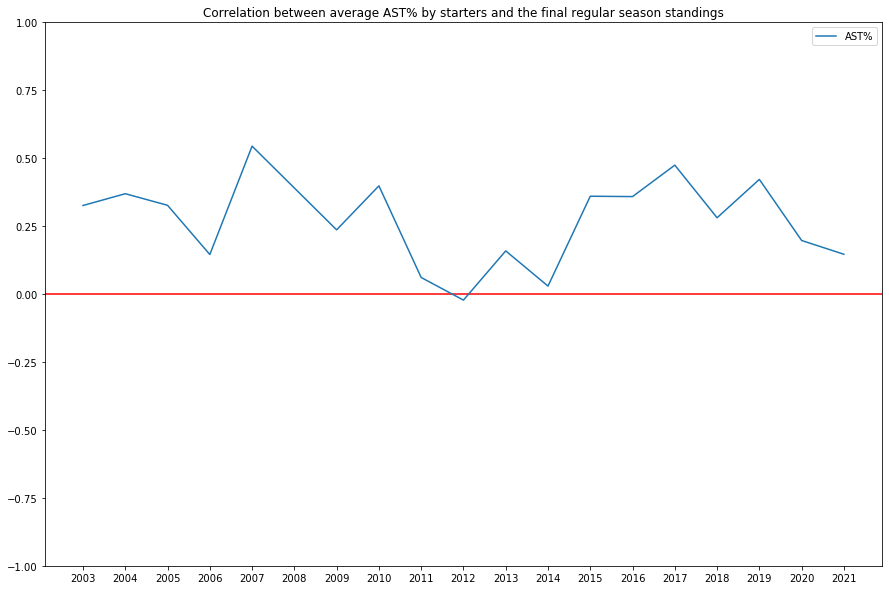

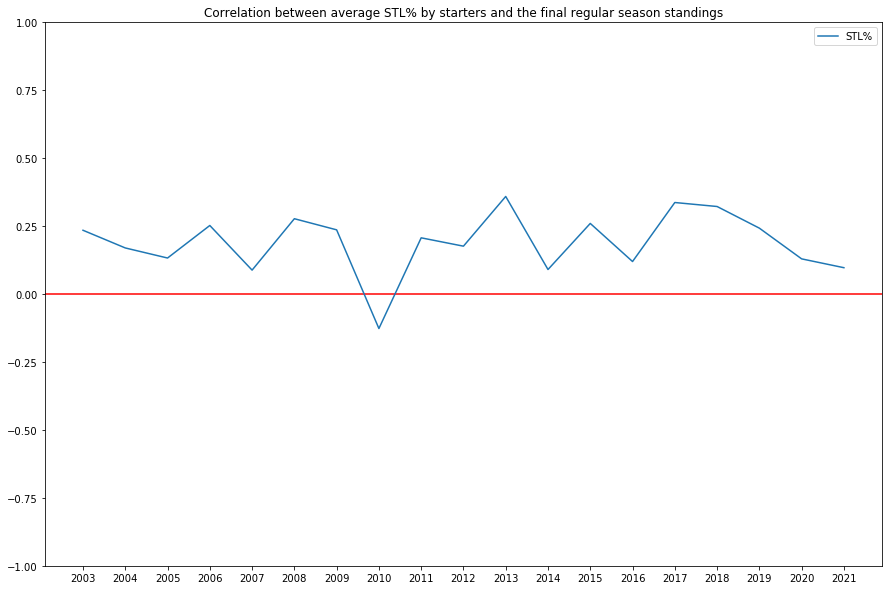

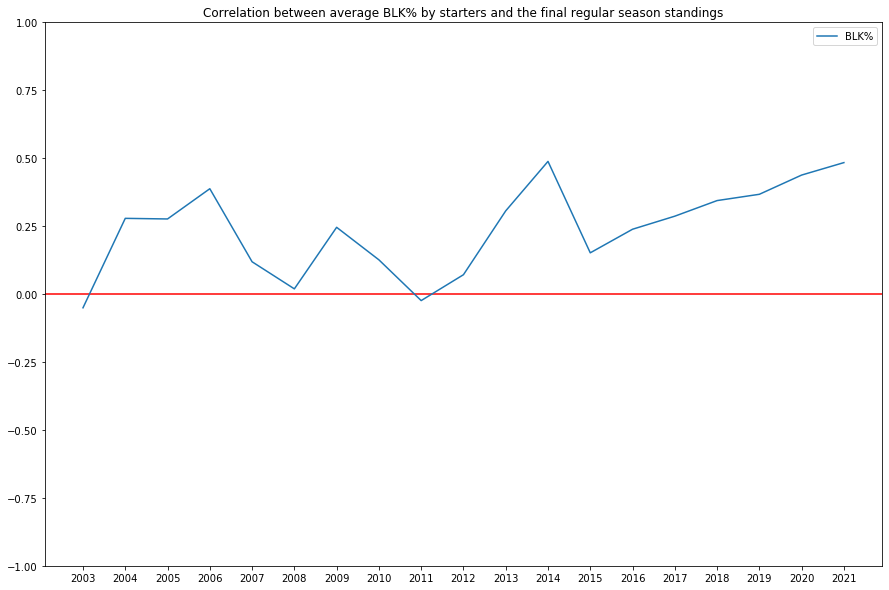

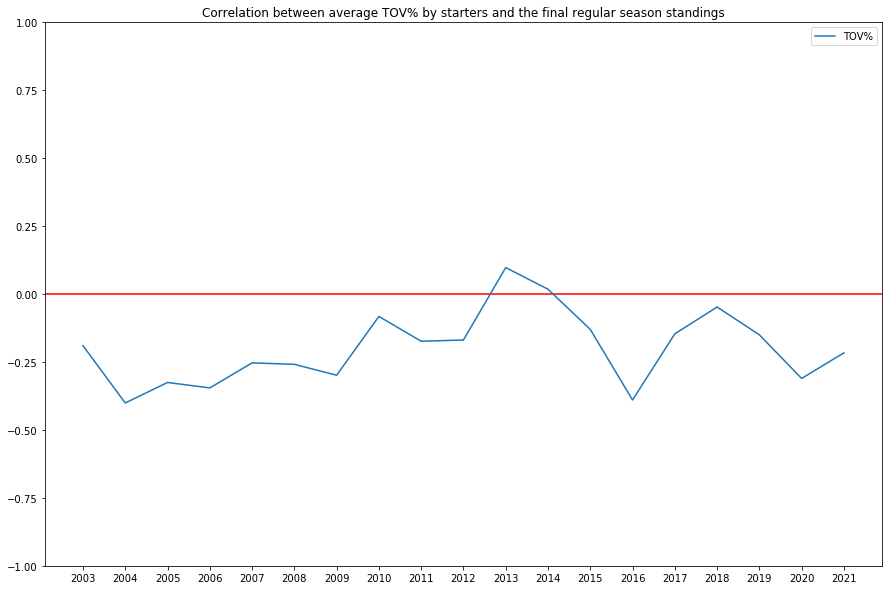

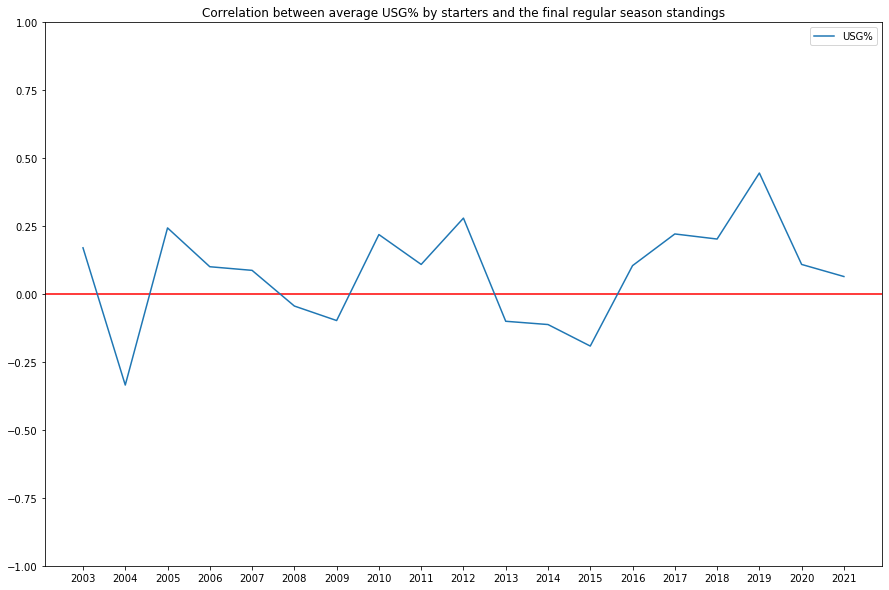

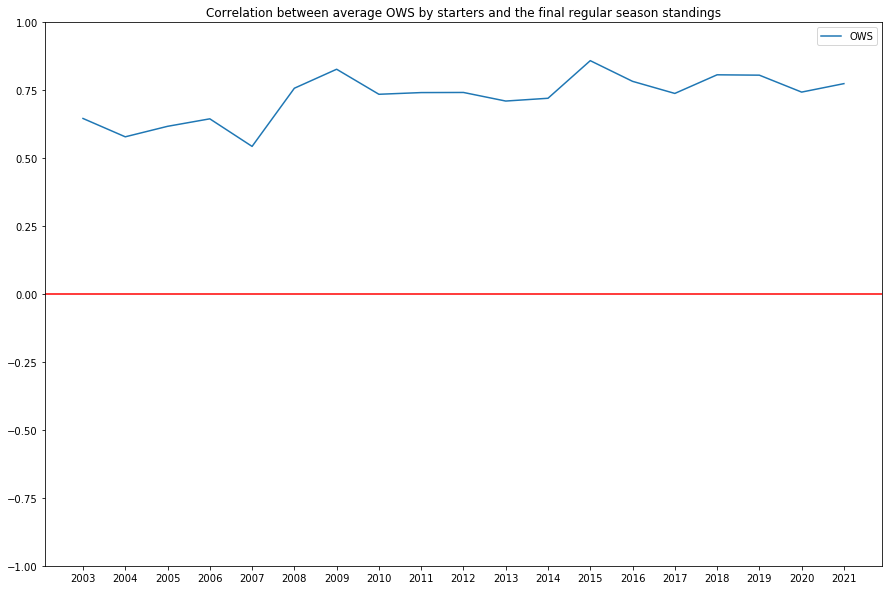

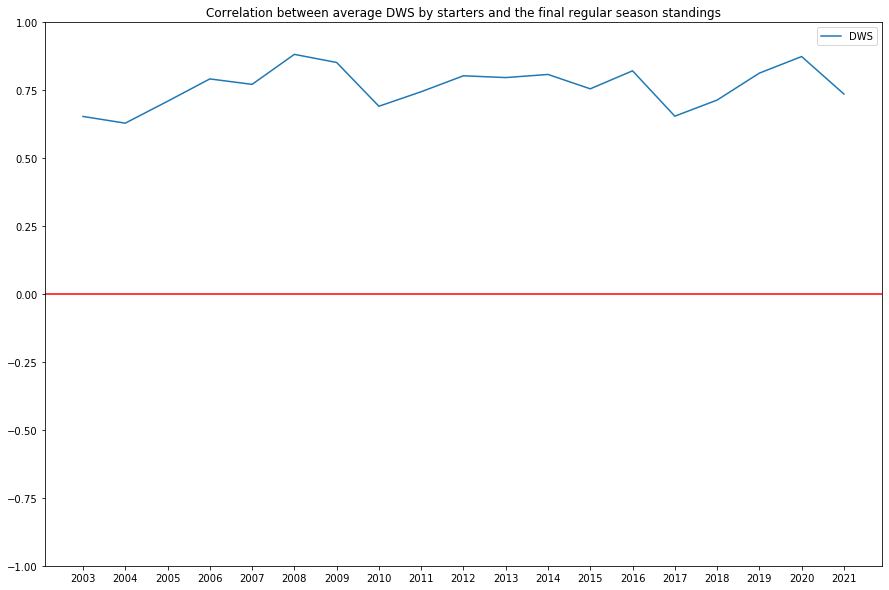

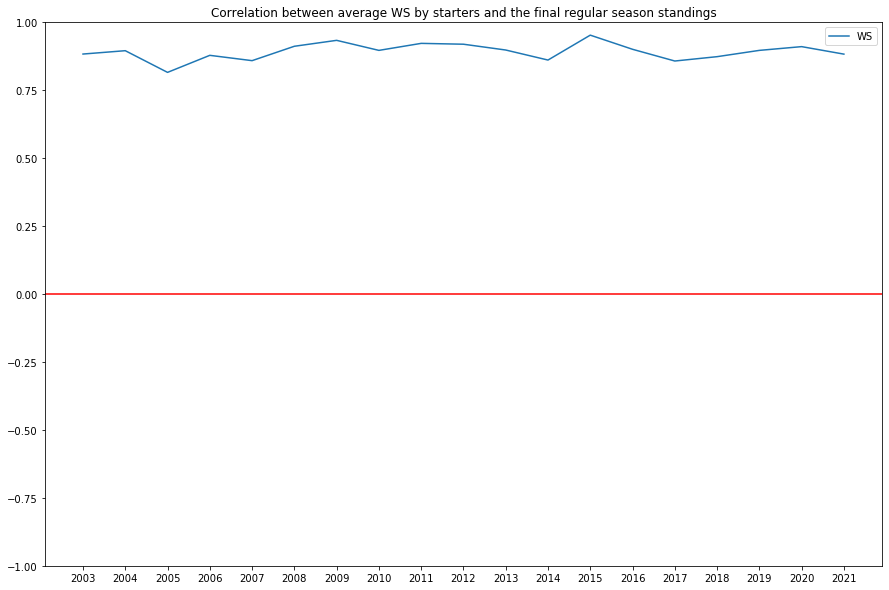

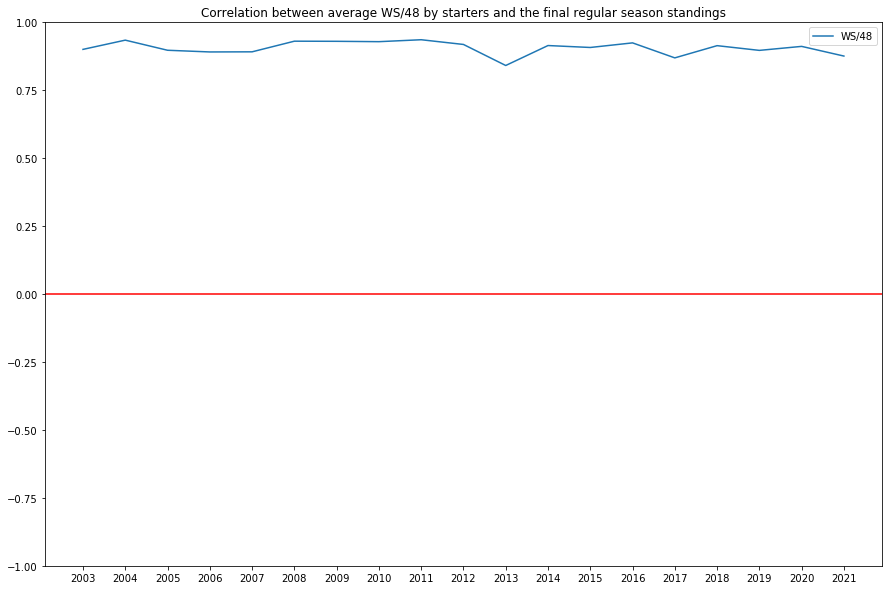

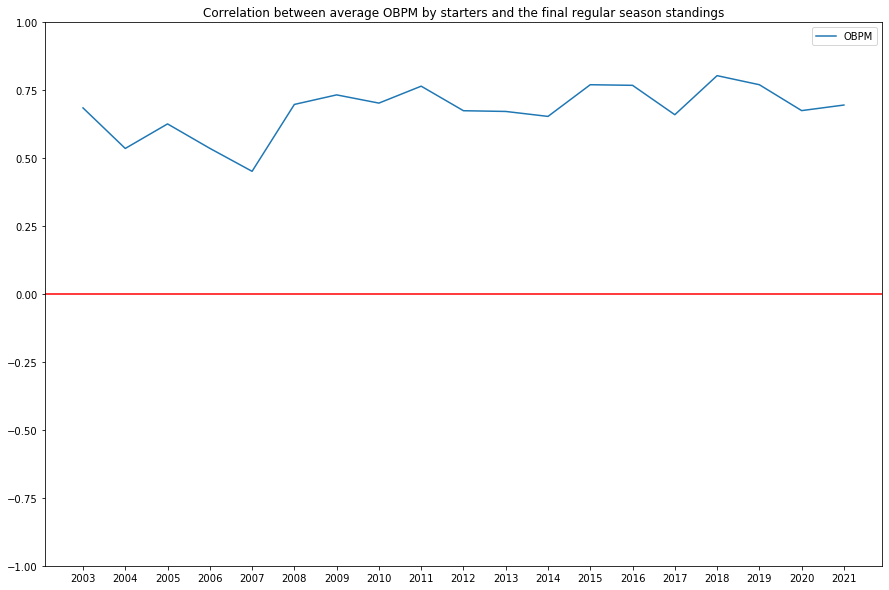

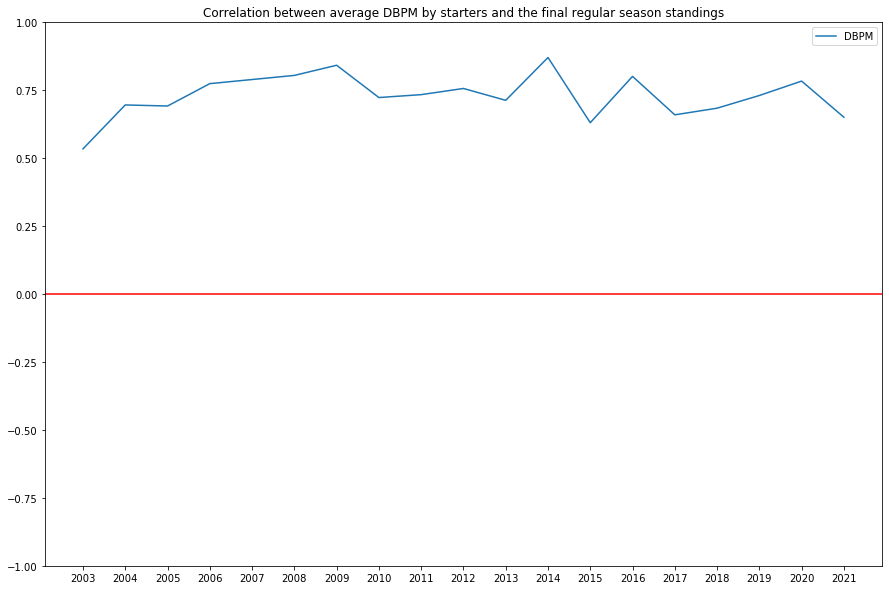

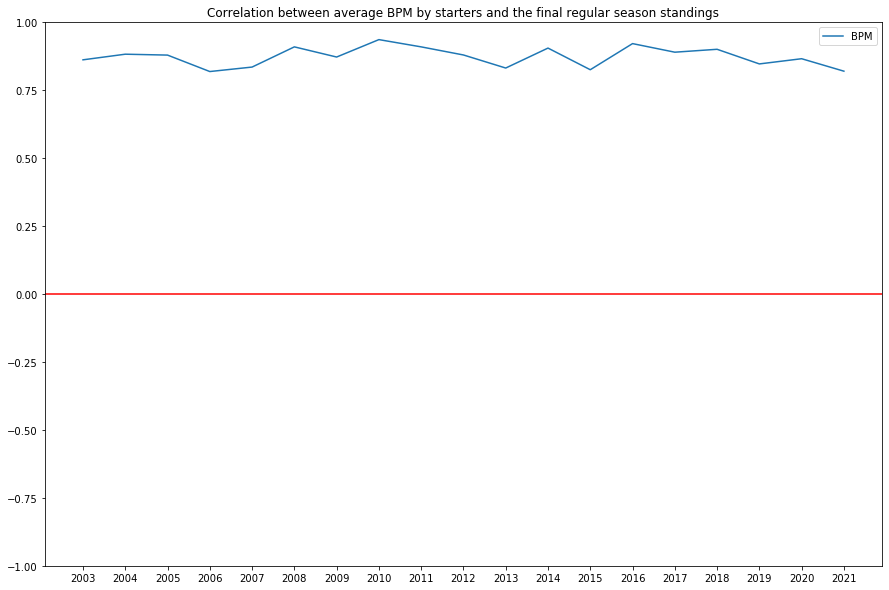

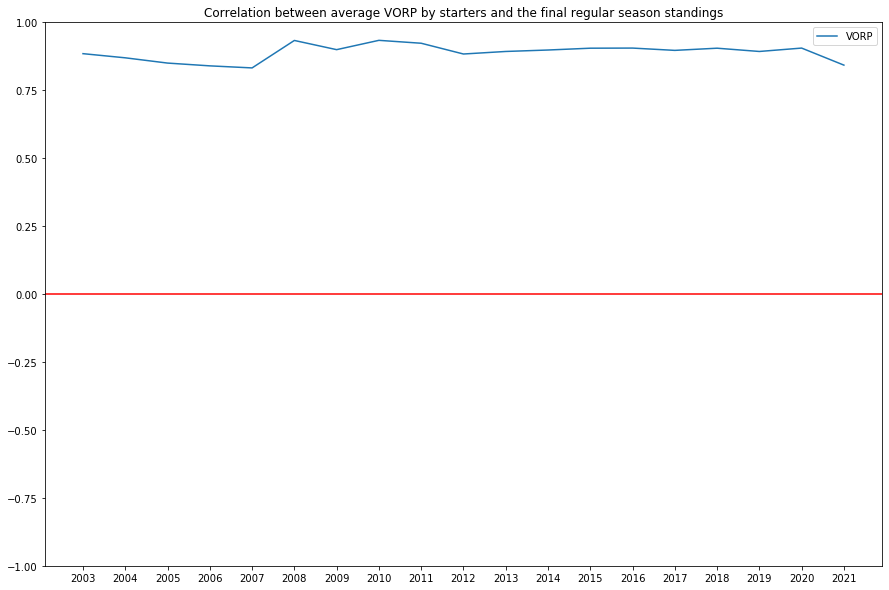

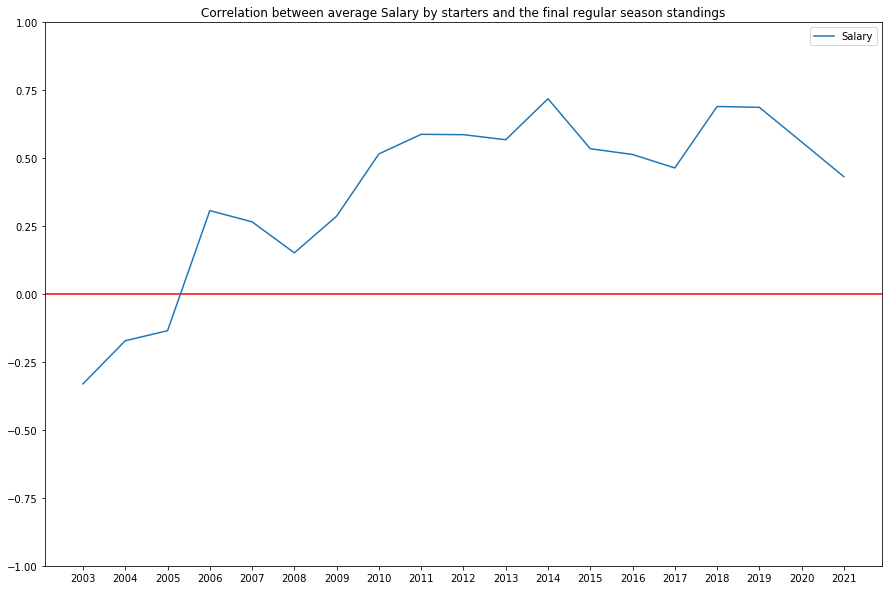

In [23]:
for stat in starters_corr.index:
    plt.figure(figsize=(15,10))
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.plot(SEASONS, starters_corr.loc[stat], label=stat)
    plt.xticks(SEASONS)
    plt.yticks([-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
    plt.title(f"Correlation between average {stat} by starters and the final regular season standings")
    plt.legend()
    plt.show()
    

In [24]:
starter_avg_per_season = {}


for stat in stats:
    starter_avg_per_season[stat] = []
    for df in starters_per_season:
        starter_avg_per_season[stat].append(df[stat].mean())

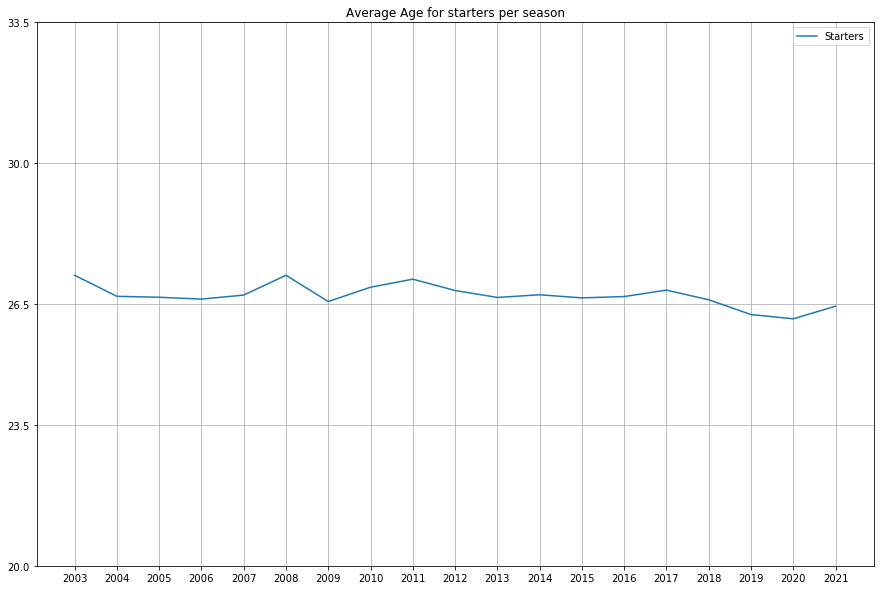

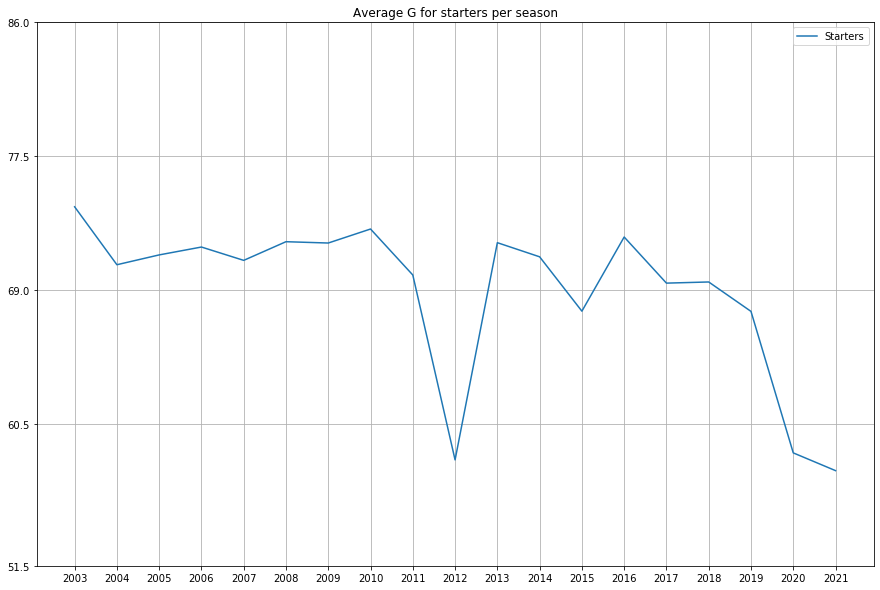

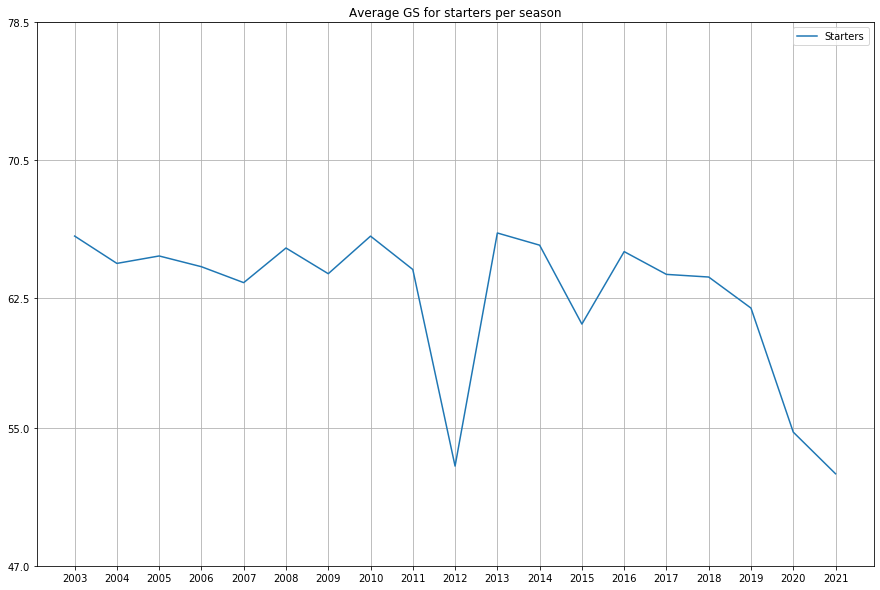

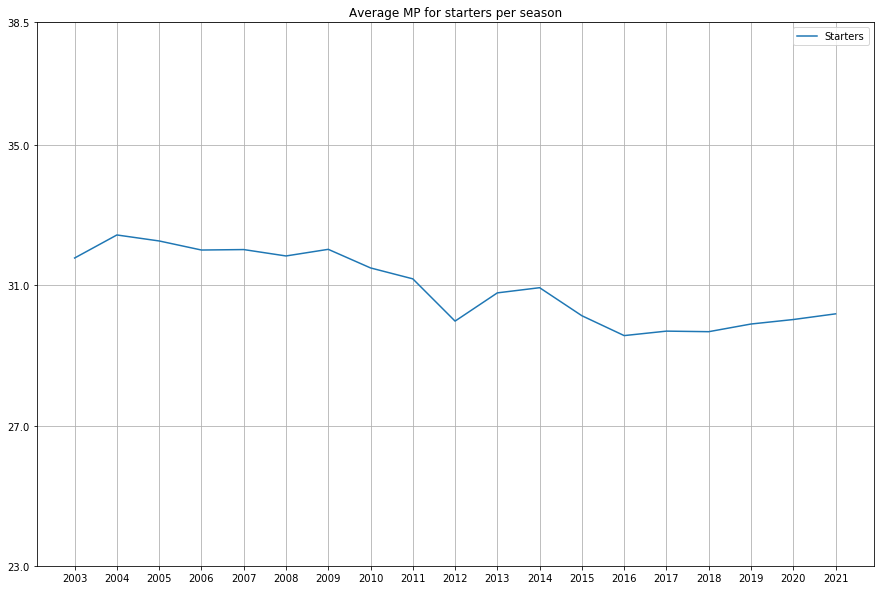

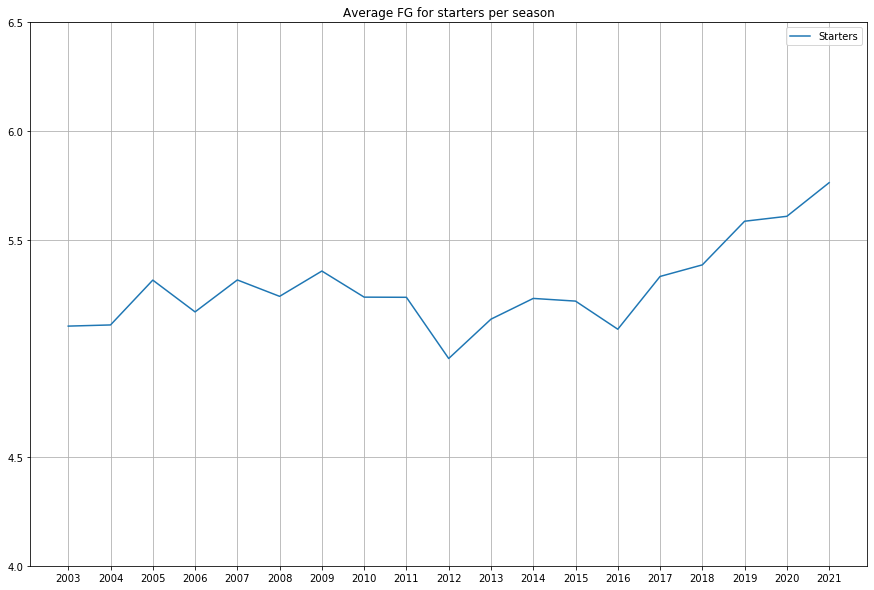

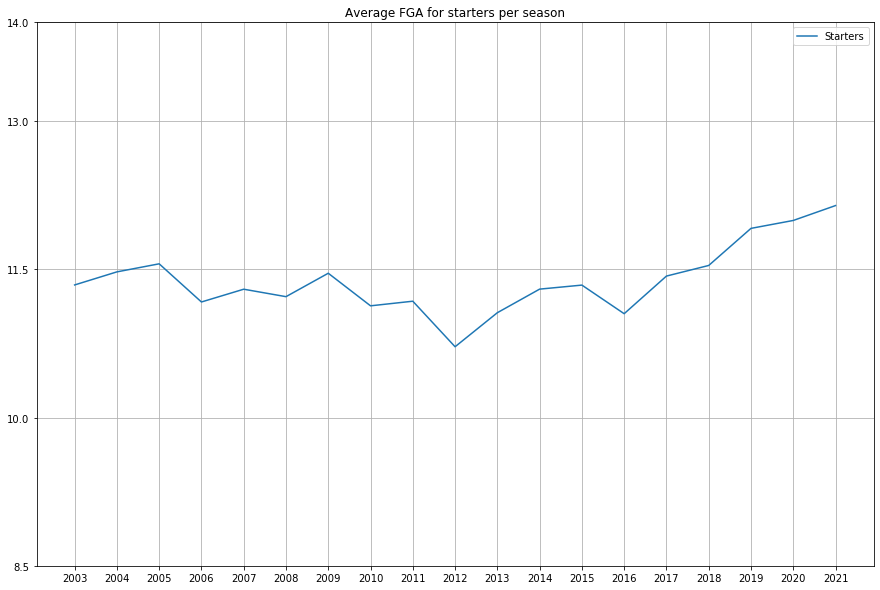

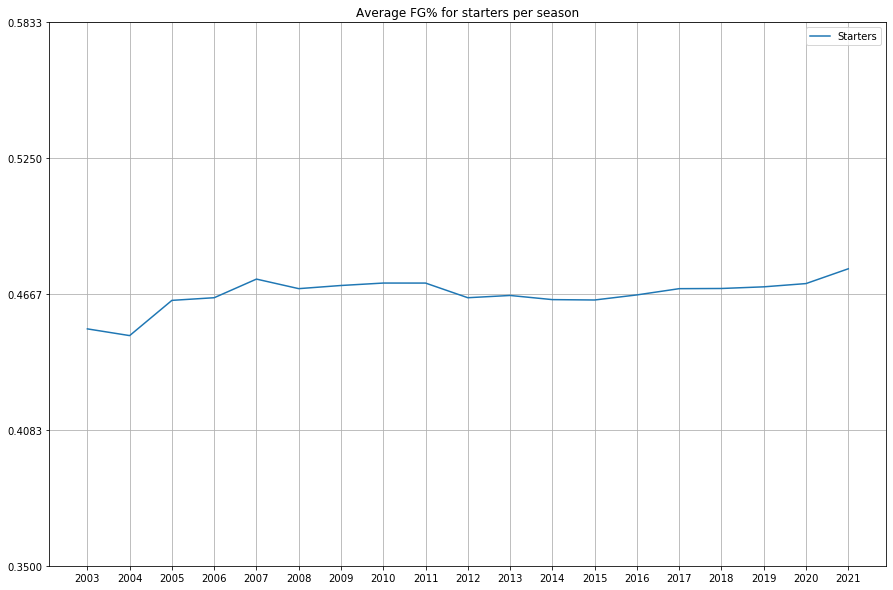

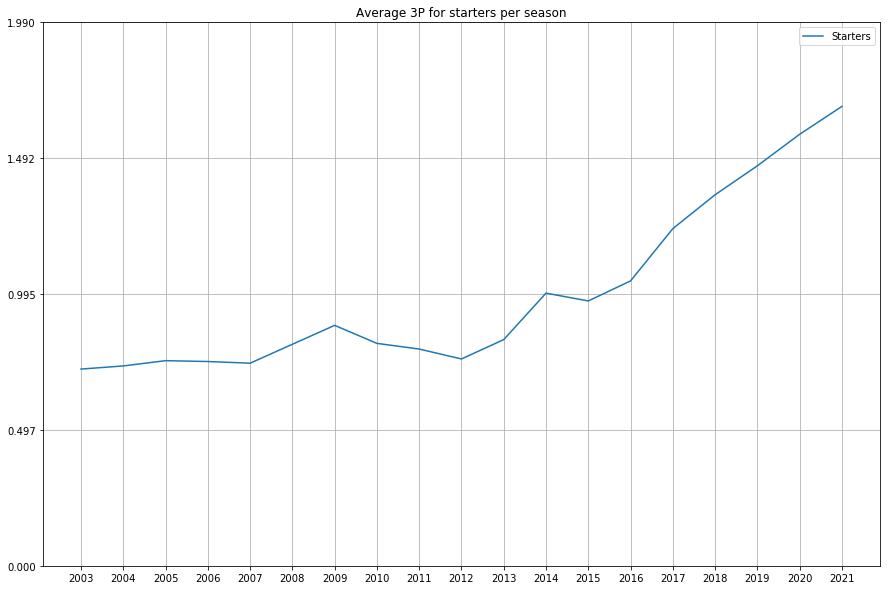

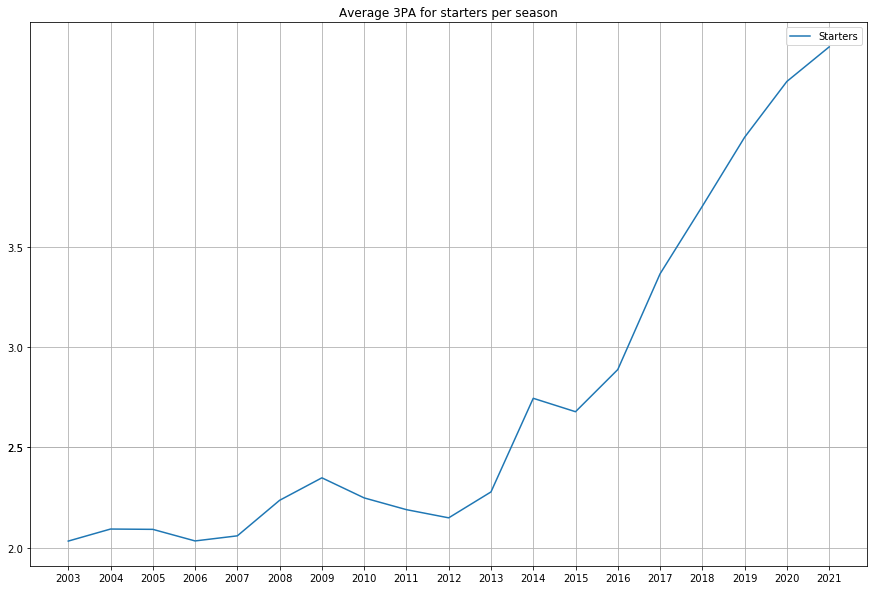

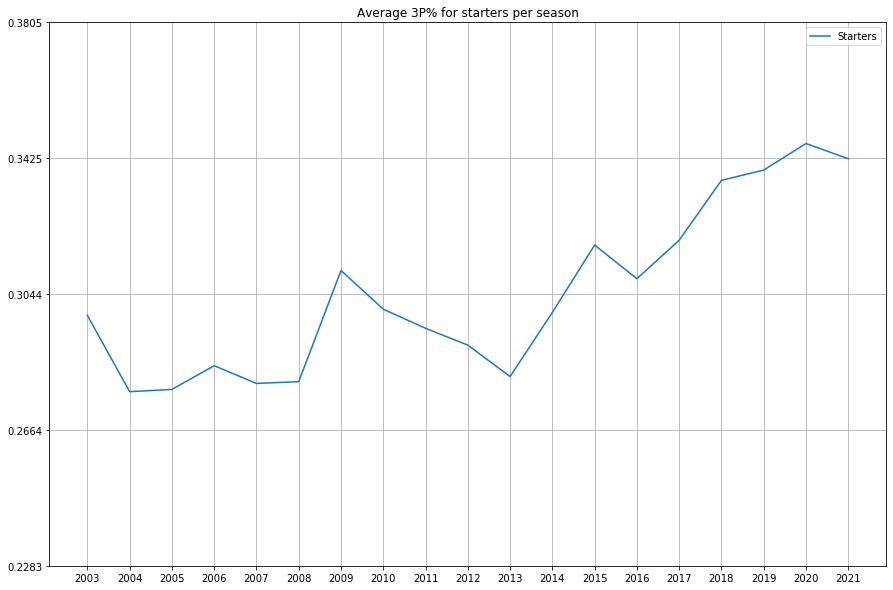

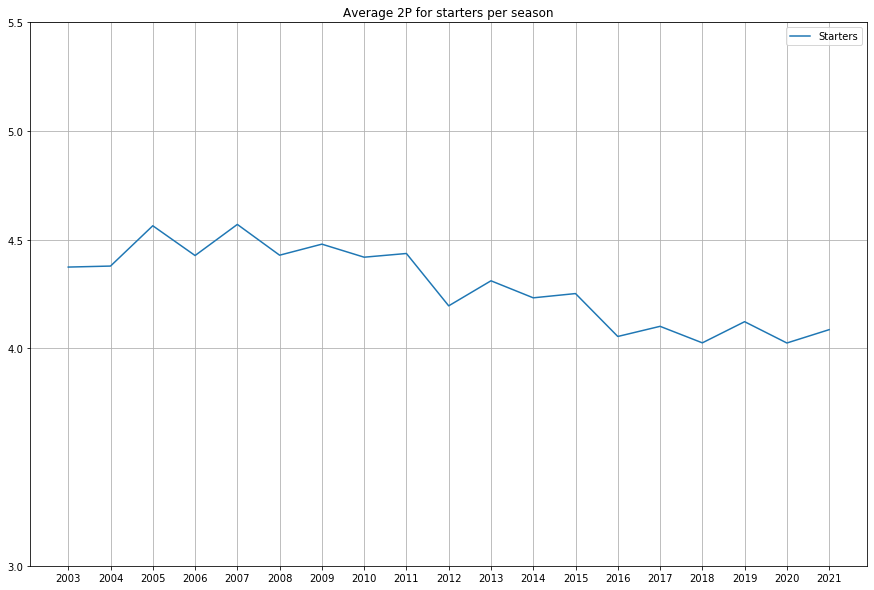

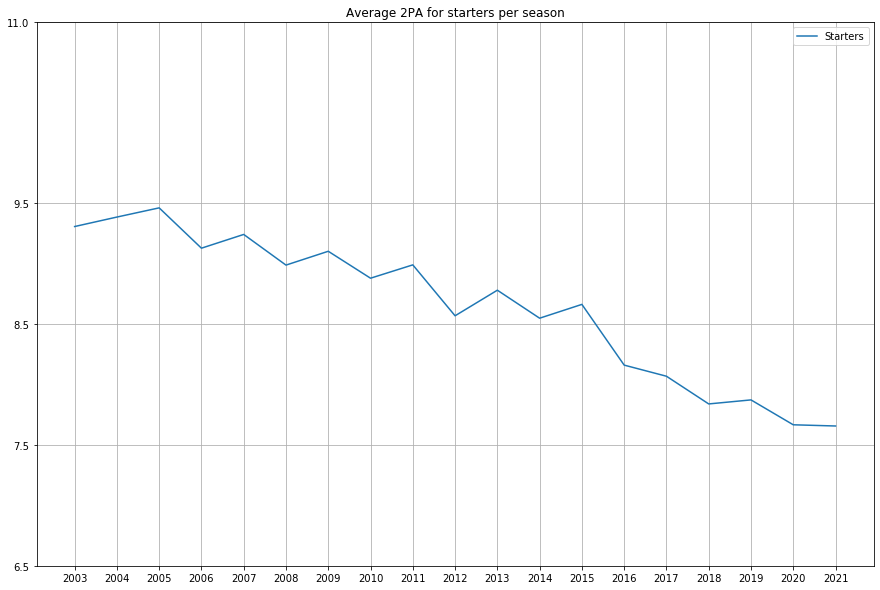

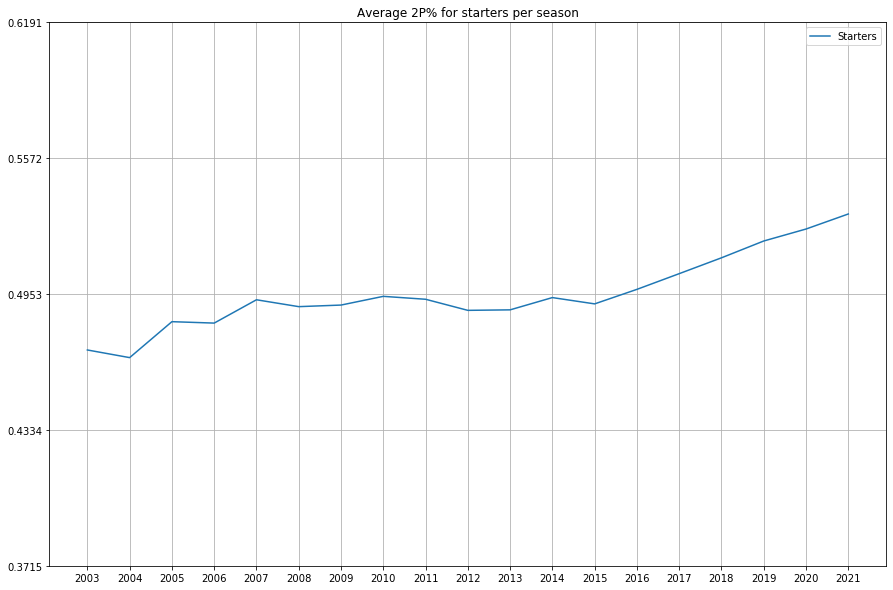

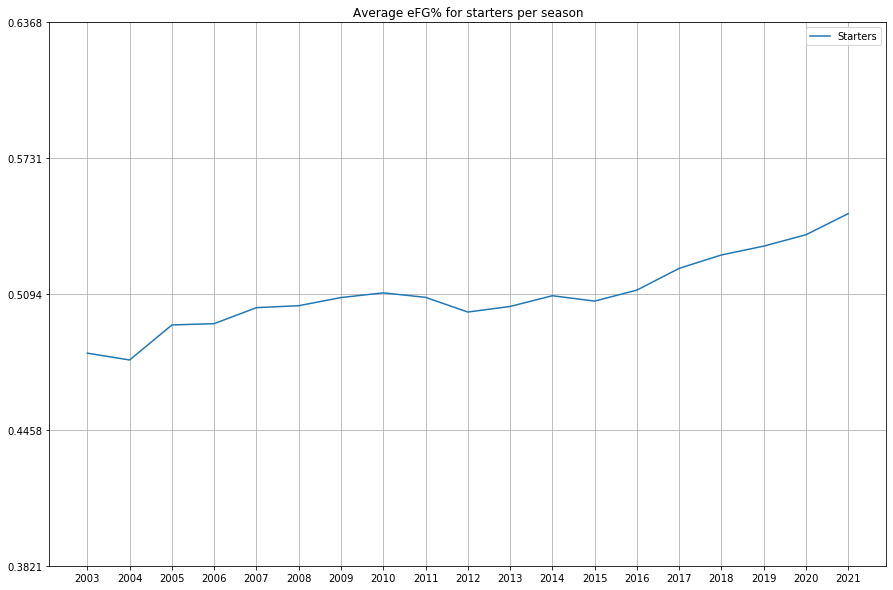

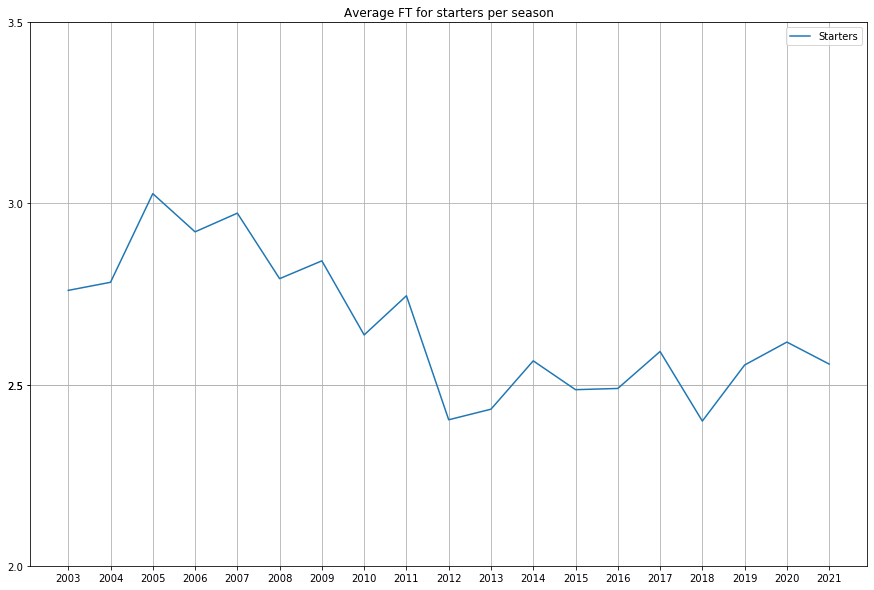

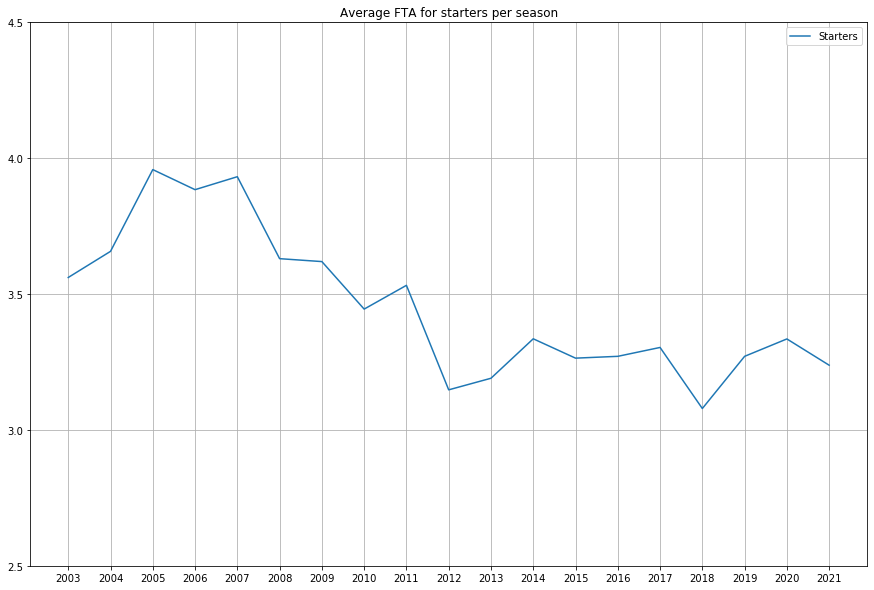

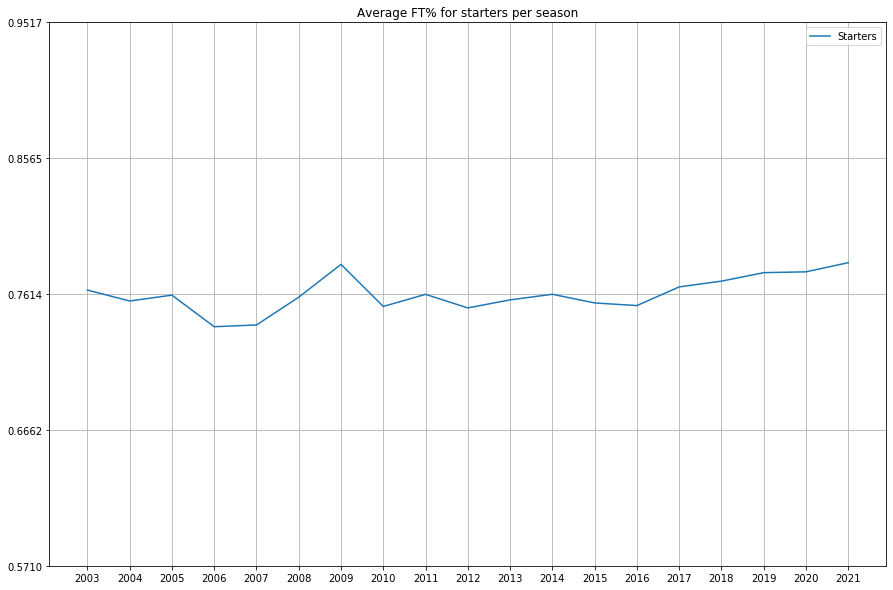

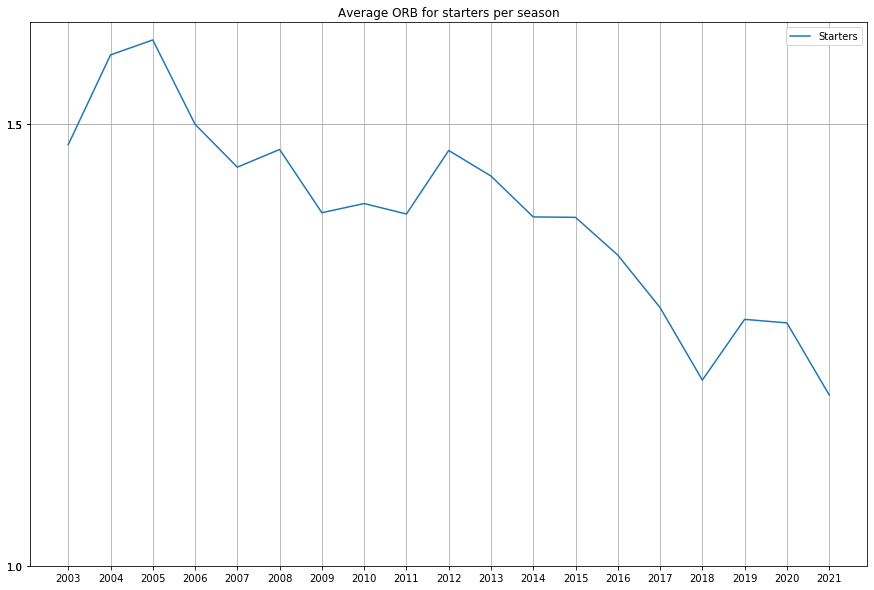

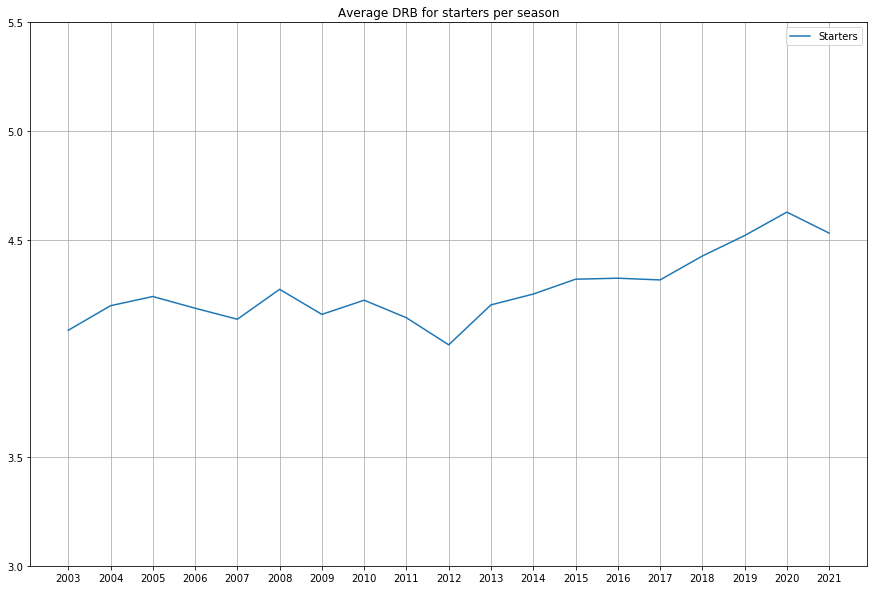

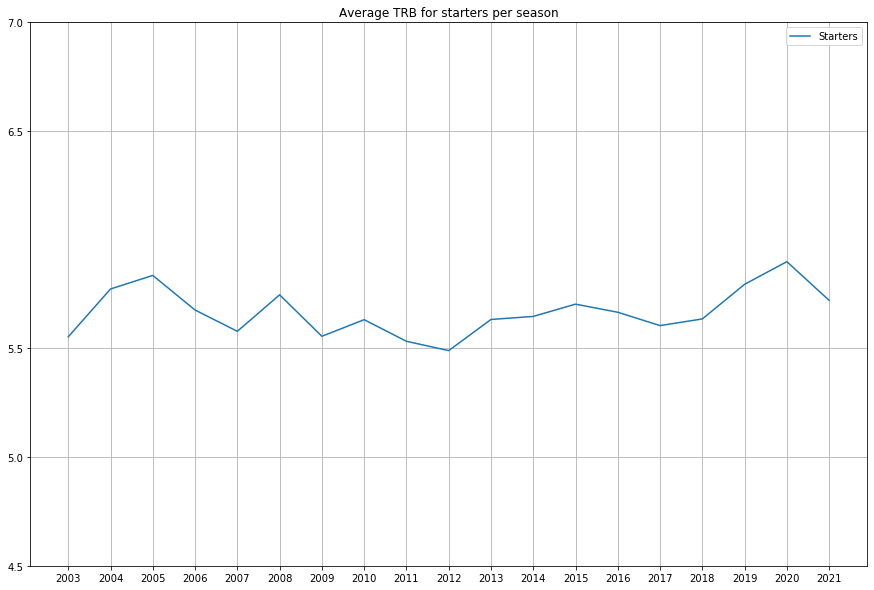

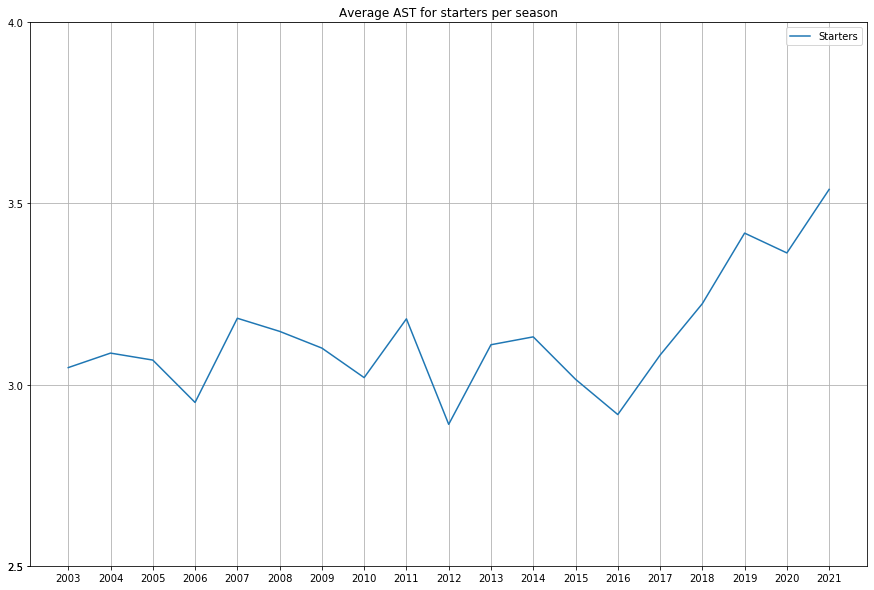

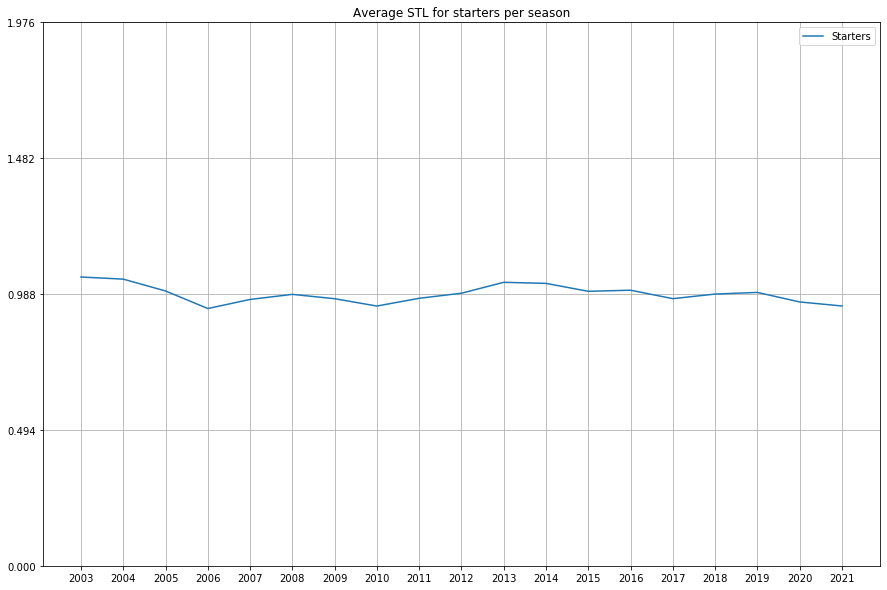

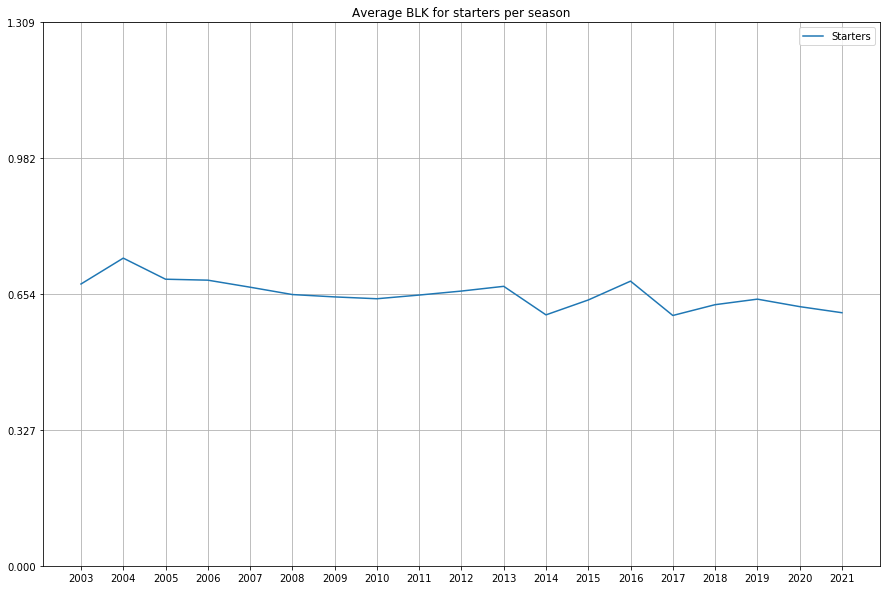

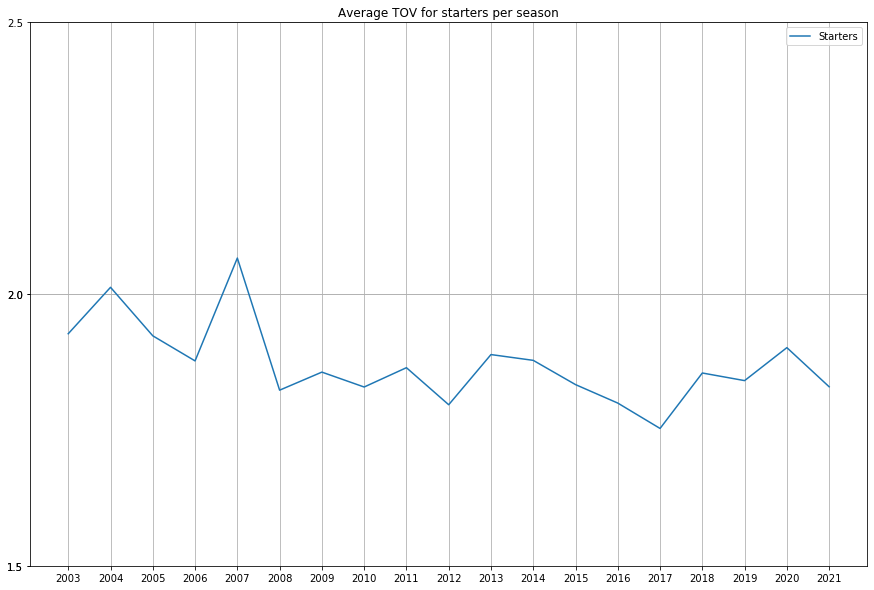

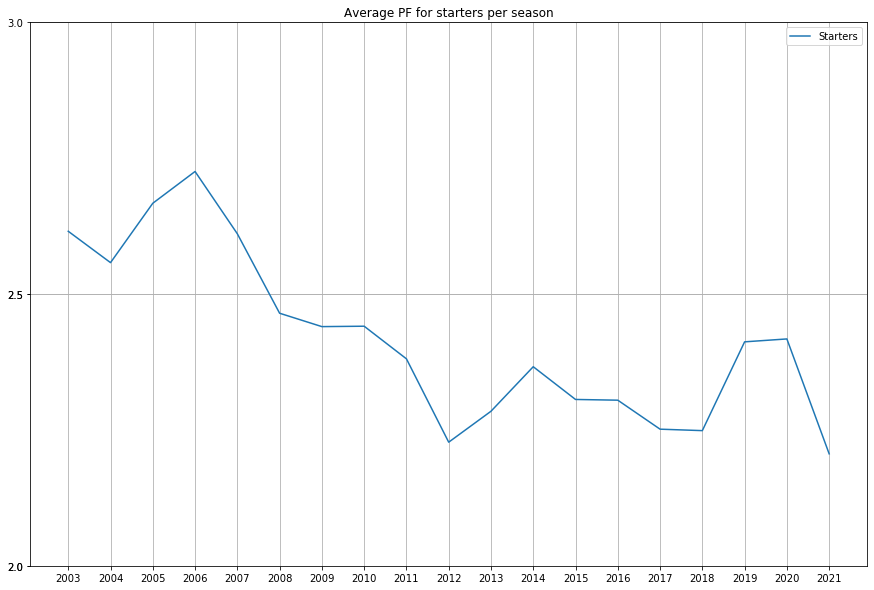

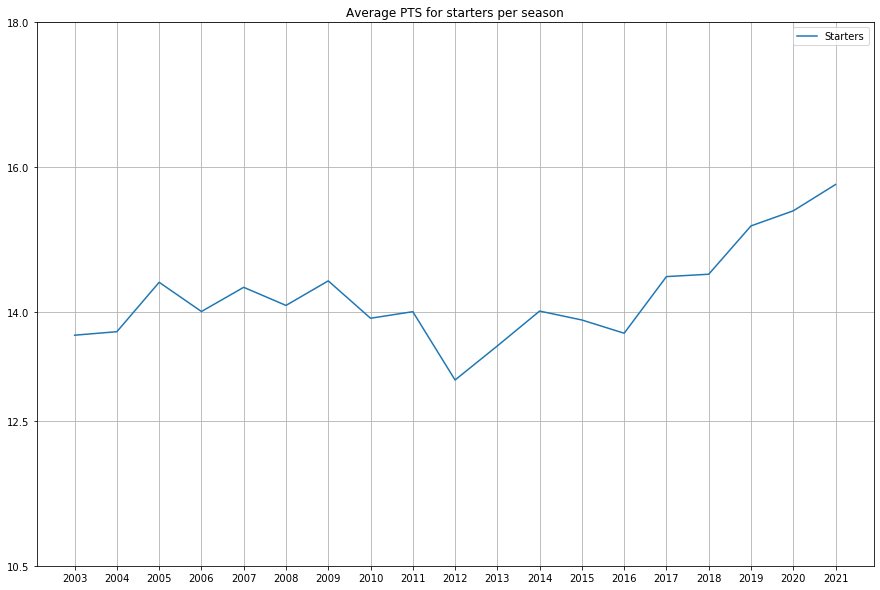

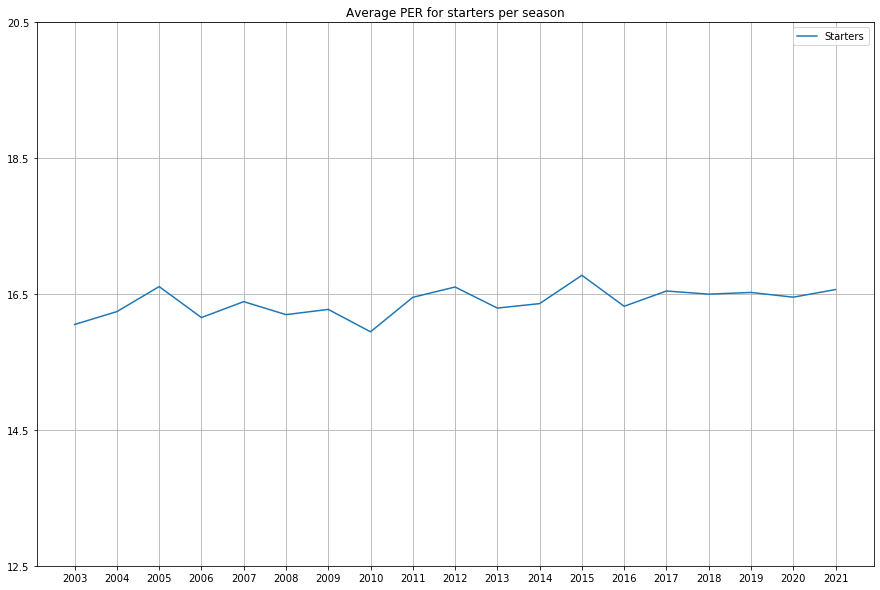

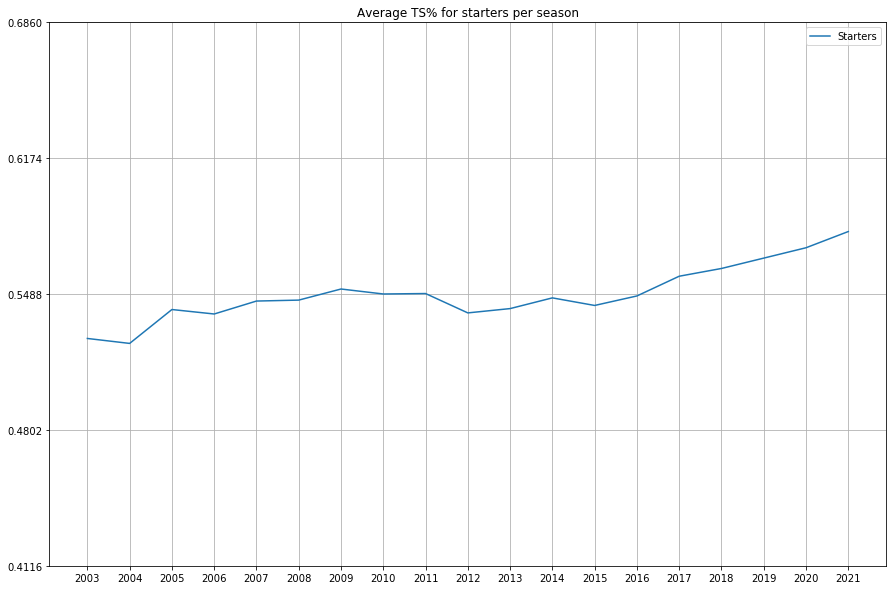

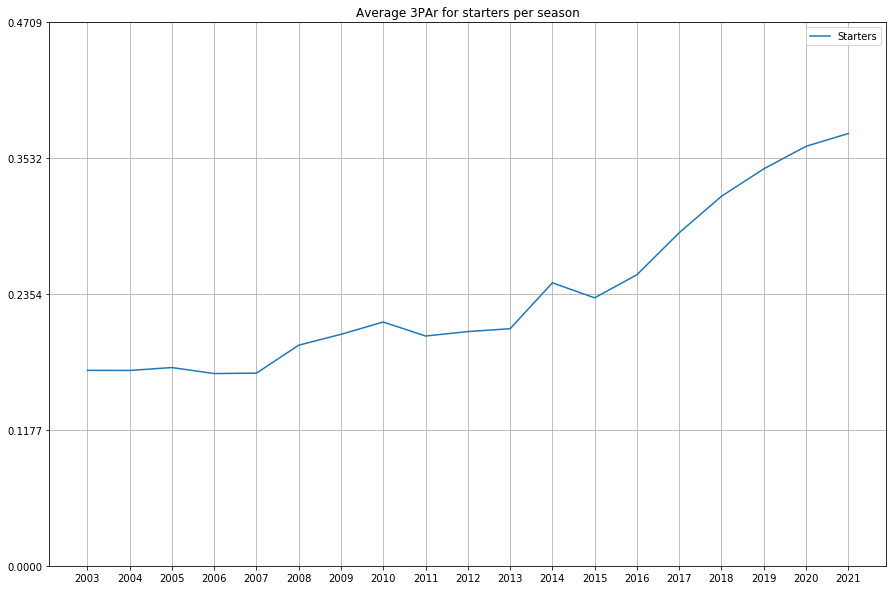

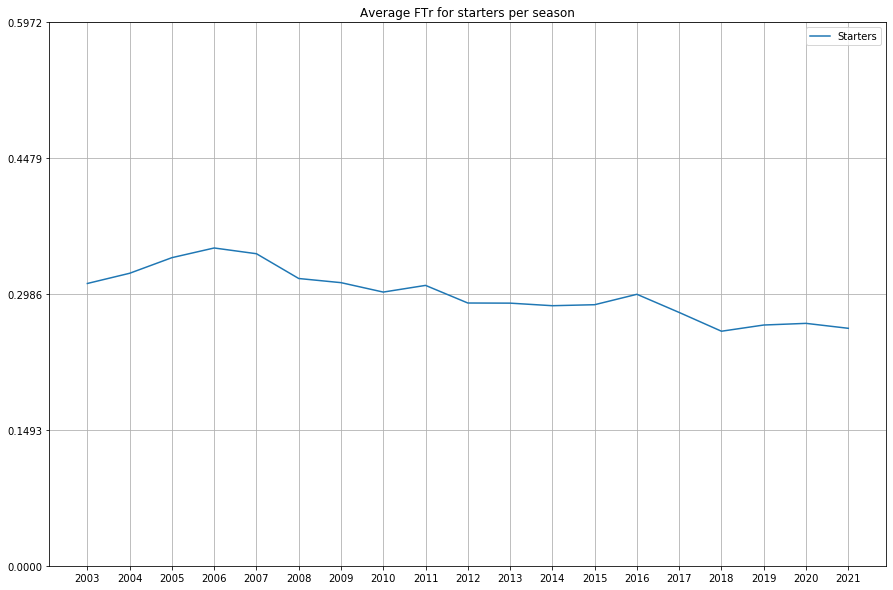

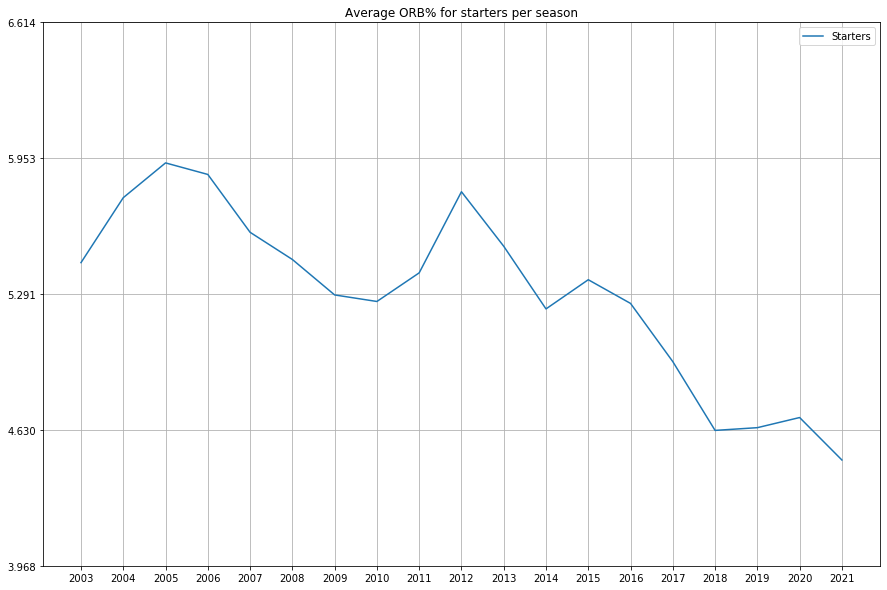

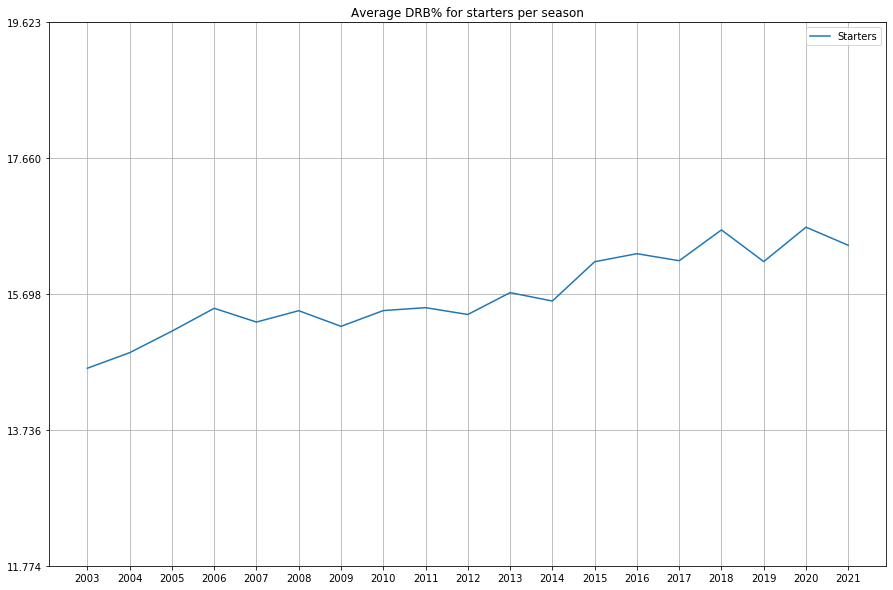

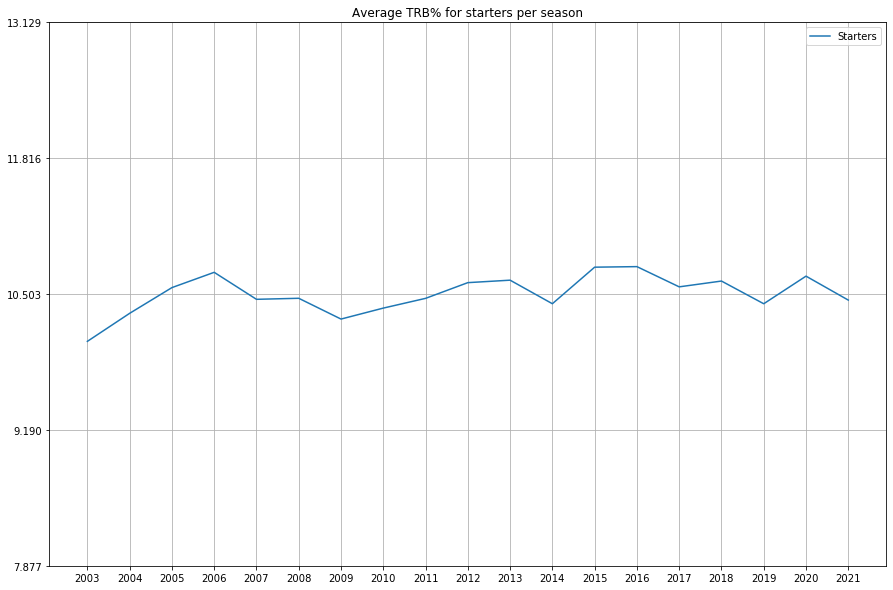

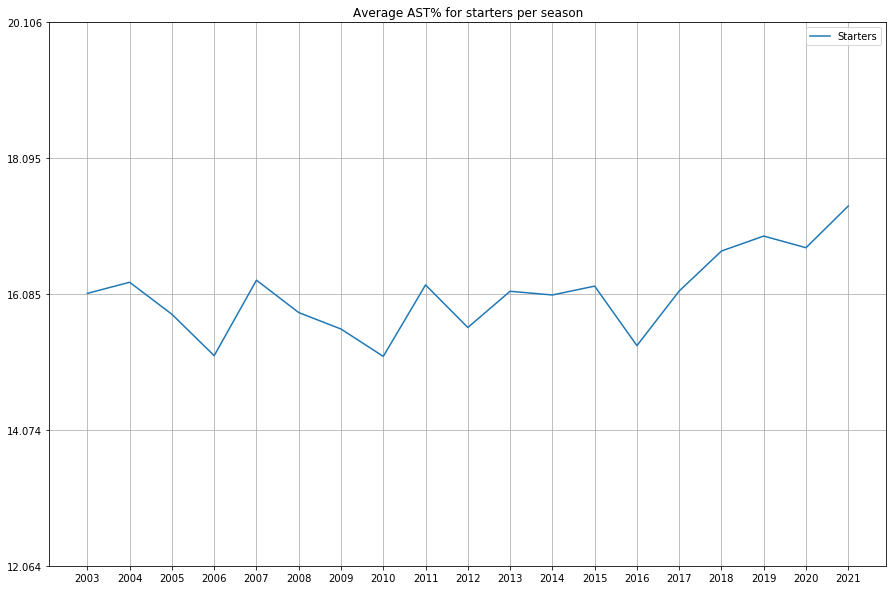

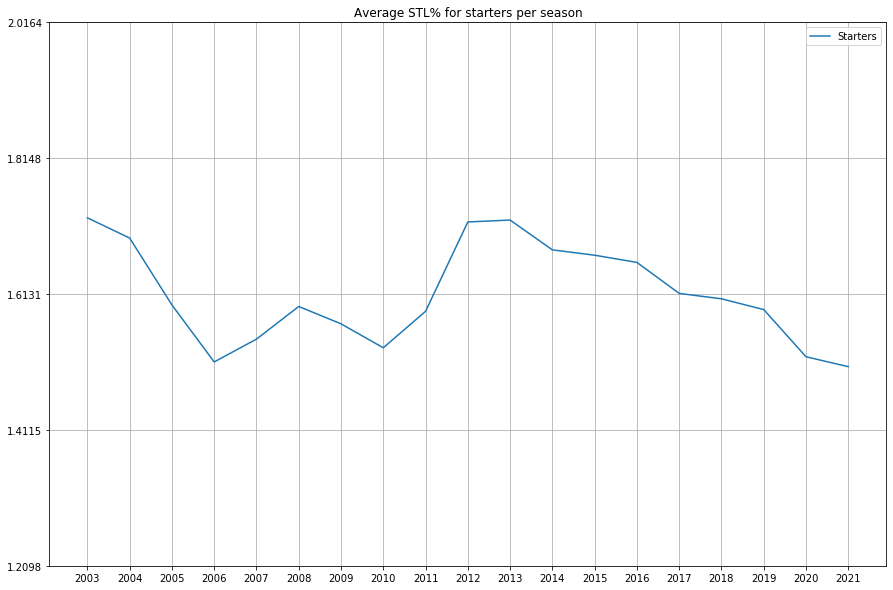

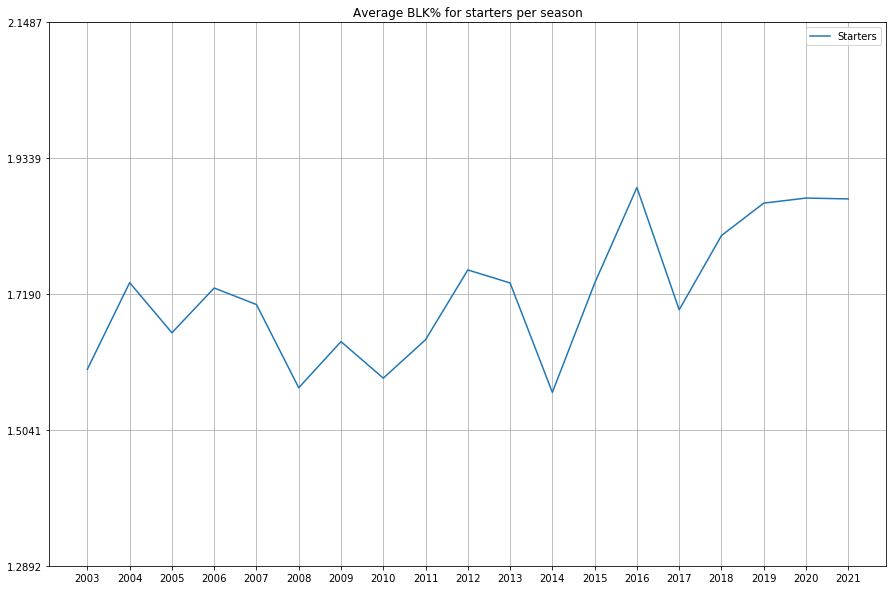

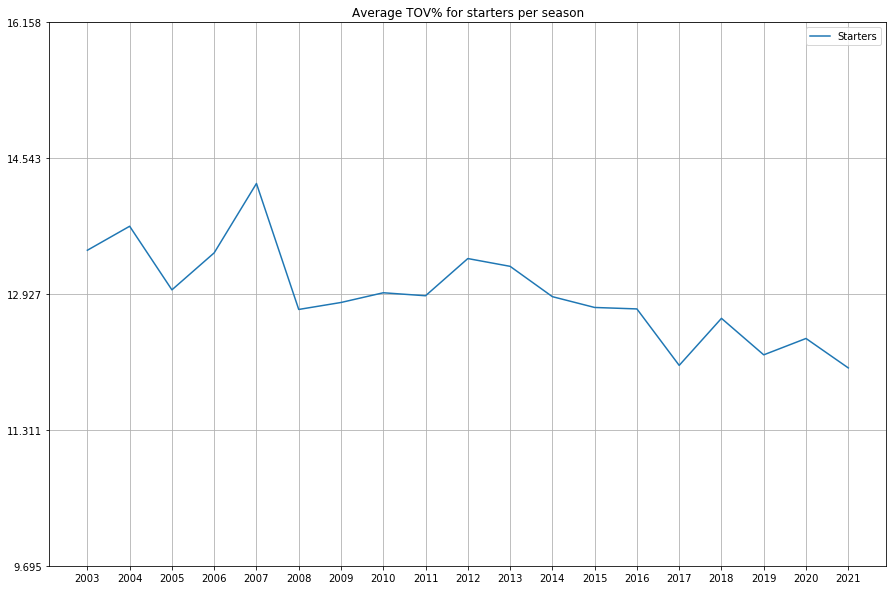

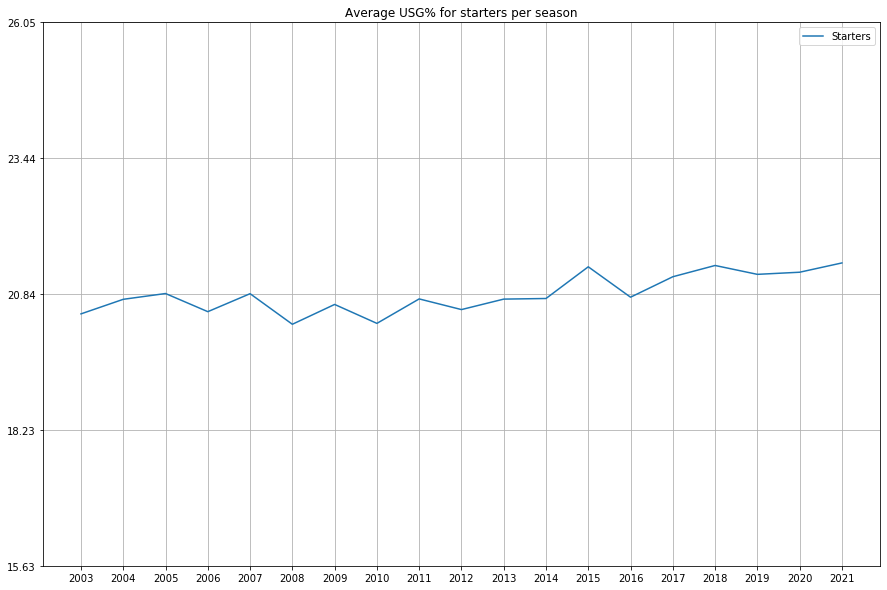

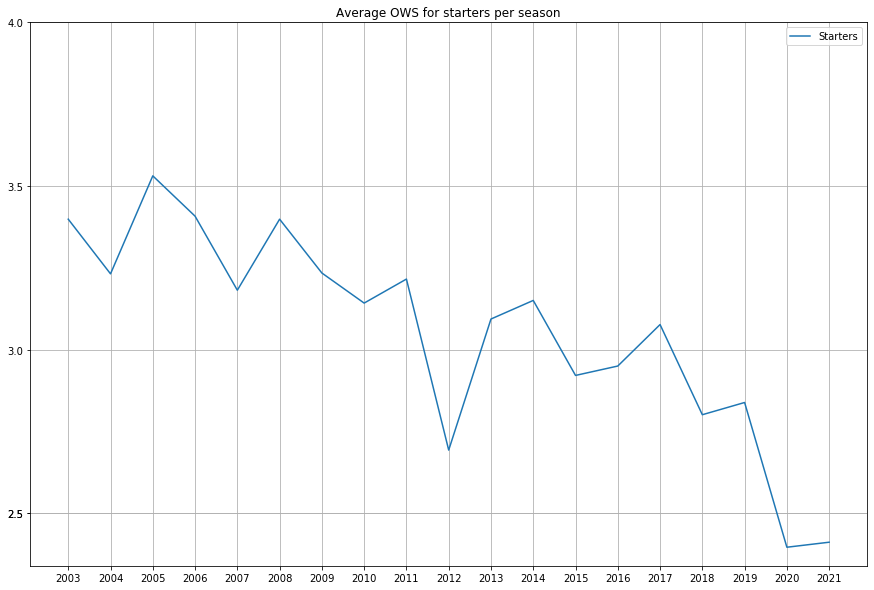

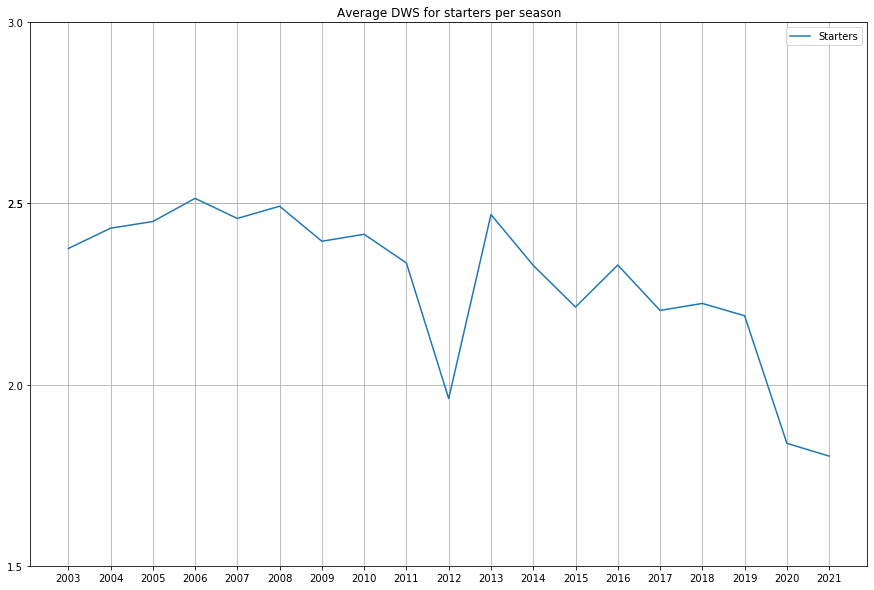

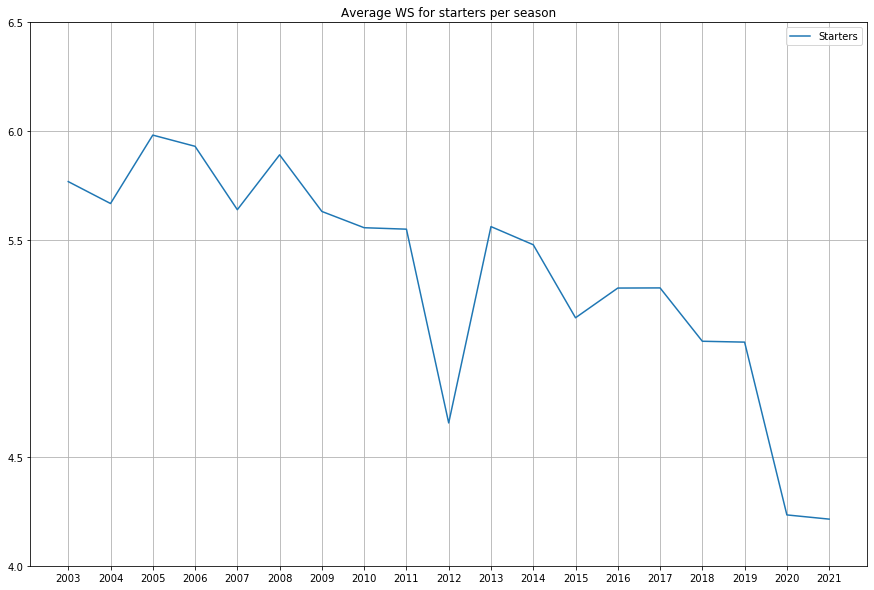

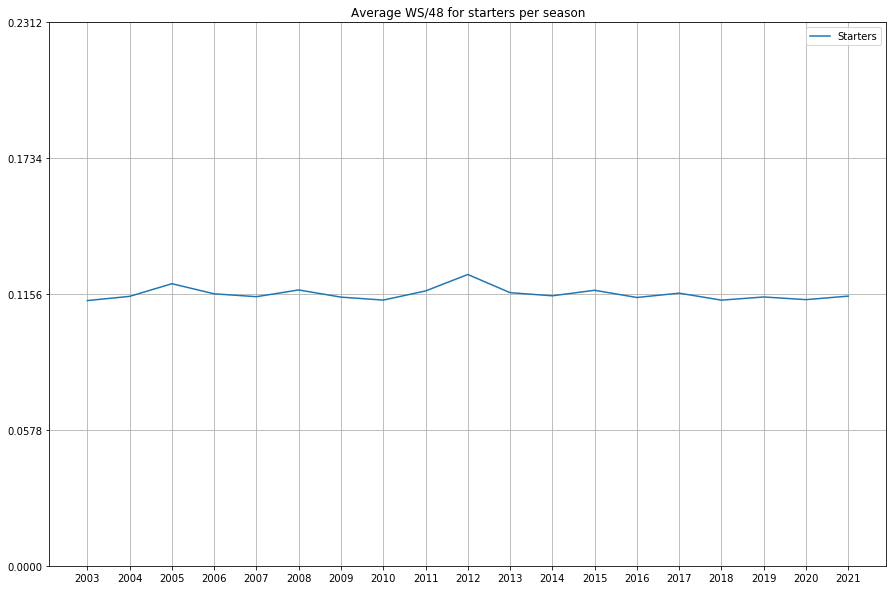

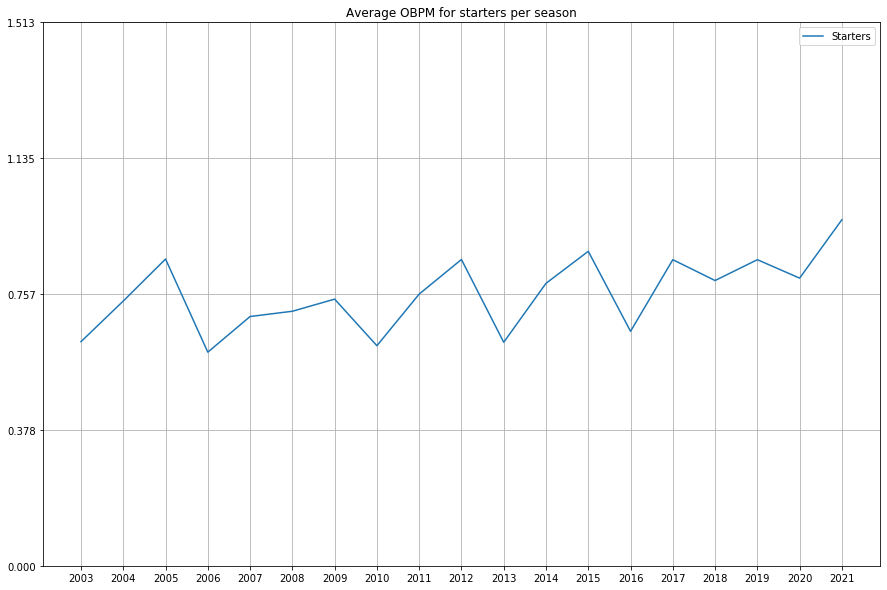

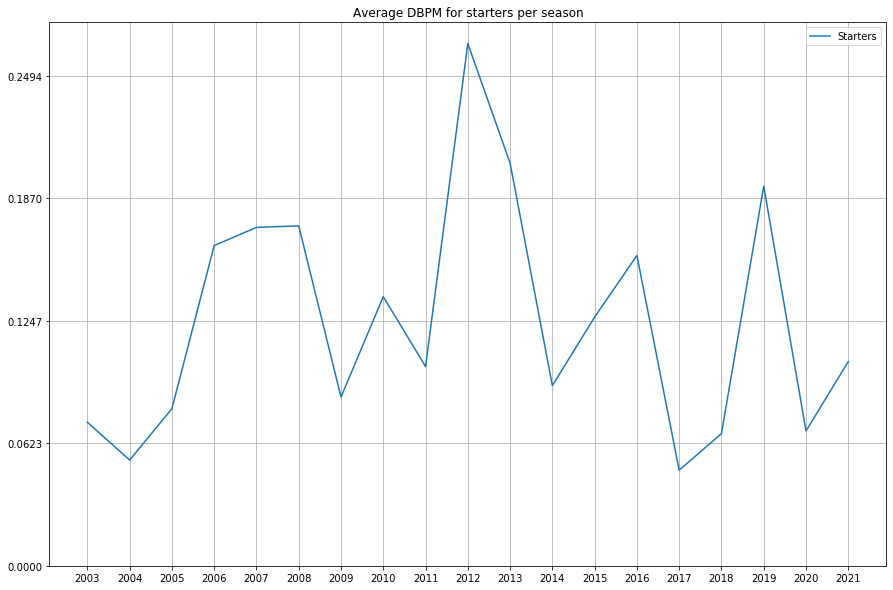

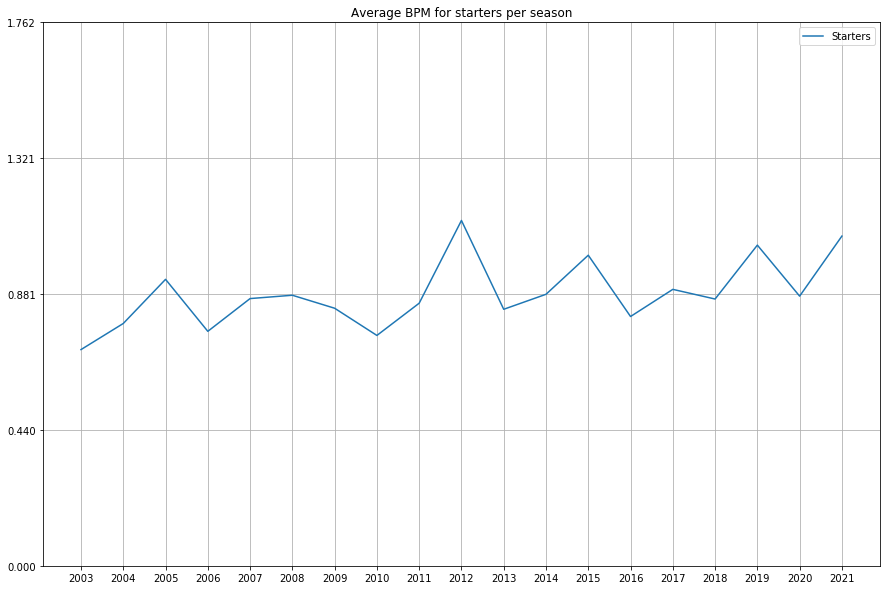

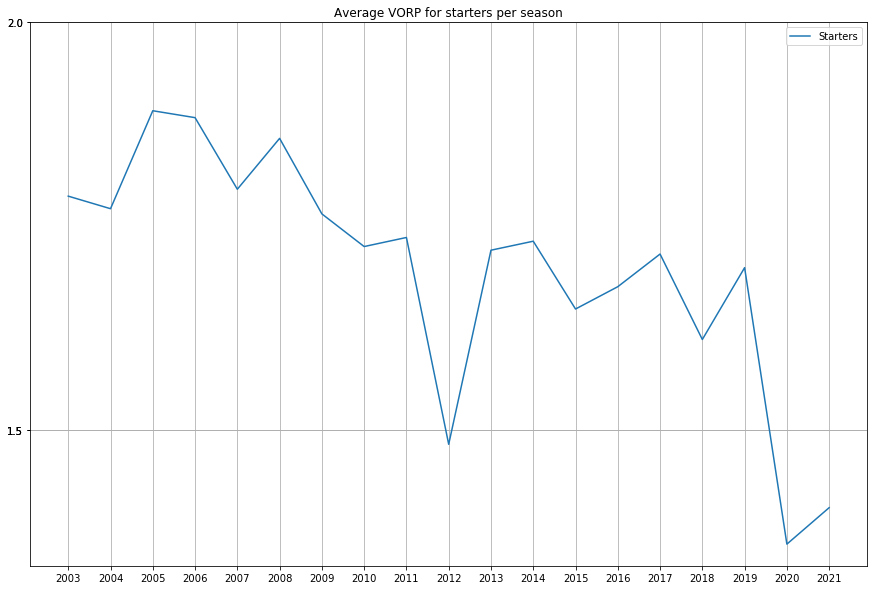

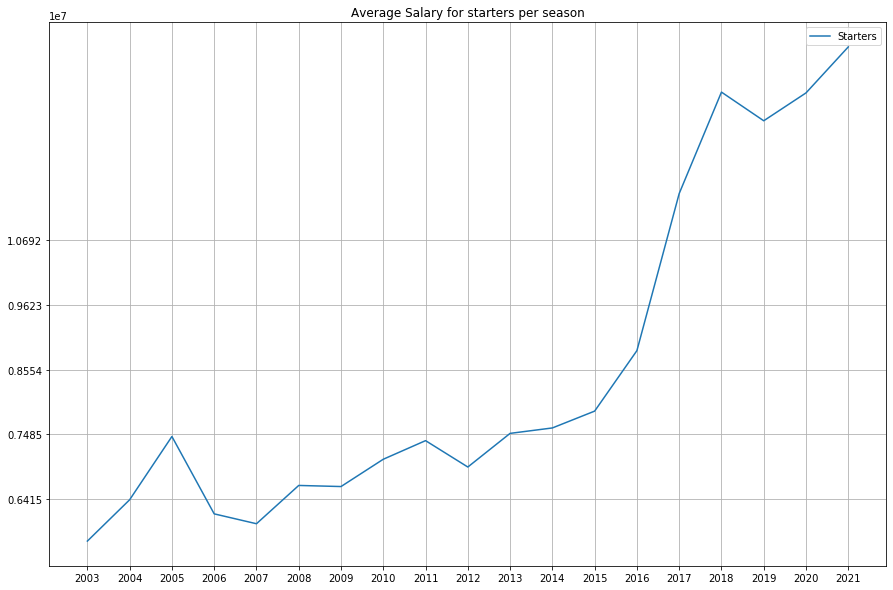

In [25]:
for stat in starter_avg_per_season:
    plt.figure(figsize=(15,10))
    plt.grid()
    plt.plot(SEASONS, starter_avg_per_season[stat], label="Starters")
    stat_mean = mean(starter_avg_per_season[stat])
    plt.xticks(SEASONS)
    if "%" in stat:
        plt.yticks([(0.75*stat_mean), (0.875*stat_mean), (stat_mean), (1.125*stat_mean), (1.25*stat_mean)])        
    elif stat_mean < 1:
        plt.yticks([(0.0), (0.5*stat_mean), (stat_mean), (1.5*stat_mean), (2*stat_mean)])        
    else:
        plt.yticks([round_closest_half(0.75*stat_mean), round_closest_half(0.875*stat_mean), round_closest_half(stat_mean), round_closest_half(1.125*stat_mean), round_closest_half(1.25*stat_mean)])
    plt.title(f"Average {stat} for starters per season")
    plt.legend()
    plt.show()